In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import copy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch import nn, optim
import torch.nn.functional as F
import argparse
import time
from tqdm import tqdm
import os
%matplotlib inline

from matplotlib import style

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
sns.set(style='dark')

In [4]:
df=pd.read_csv('fft_normal.csv')
df.head()

SK_Well Failure1_CulpritCause Failure2_CulpritCause Failure3_CulpritCause  \
0  0001d449  Механические примеси            Неизвестно            Неизвестно   
1  0001d449  Механические примеси            Неизвестно            Неизвестно   
2  0001d449  Механические примеси            Неизвестно            Неизвестно   
3  0001d449  Механические примеси            Неизвестно            Неизвестно   
4  0001d449  Механические примеси            Неизвестно            Неизвестно   

  Failure4_CulpritCause Failure5_CulpritCause Failure6_CulpritCause  \
0            Неизвестно            Неизвестно            Неизвестно   
1            Неизвестно            Неизвестно            Неизвестно   
2            Неизвестно            Неизвестно            Неизвестно   
3            Неизвестно            Неизвестно            Неизвестно   
4            Неизвестно            Неизвестно            Неизвестно   

  Failure7_CulpritCause  MeasureMRM12  MeasureMRM142  ...  \
0            Неизвестно          52.0           18.9  ...   
1            Неизвестно          52.0           19.0  ...   
2            Неизвестно          51.0           19.2  ...   
3            Неизвестно          51.0           19.4  ...   
4            Неизвестно          50.0           18.9  ...   

   MeasureMRM143_fft_real  MeasureMRM143_fft_imag  MeasureMRM187_fft_real  \
0             8170.200000               -0.000000            48728.300000   
1             1291.619313            -1335.352455              868.460783   
2             -117.777810            -1290.529646              -32.692478   
3             -422.617622             -349.107543             -259.515873   
4              116.671274              -25.358091               60.397190   

   MeasureMRM187_fft_imag  MeasureMRM188_fft_real  MeasureMRM188_fft_imag  \
0               -0.000000            16204.000000               -0.000000   
1             -916.119648              212.657208             -340.857618   
2             -867.398337             -216.580337               44.367092   
3             -271.679124              202.779589              -64.545014   
4              -68.596063              231.073352              -71.213199   

   MeasureMRM219_fft_real  MeasureMRM219_fft_imag  MeasureMRM204_fft_real  \
0            7.005743e+06               -0.000000             1971.700000   
1           -1.190678e+05           111285.292378             1433.964507   
2           -1.038651e+04           161153.182694              497.119567   
3            1.022281e+05           122528.265353              271.180072   
4            1.568124e+05            17580.120905              831.043020   

   MeasureMRM204_fft_imag  
0               -0.000000  
1              938.367918  
2              907.924700  
3              207.572674  
4              -71.459933  

[5 rows x 30 columns]

In [5]:
anom=pd.read_csv('fft_anomaly.csv')
anom.head()

SK_Well Failure1_CulpritCause       Failure2_CulpritCause  \
0  0001d449  Механические примеси  Коррозионная агрессивность   
1  0001d449  Механические примеси  Коррозионная агрессивность   
2  0001d449  Механические примеси  Коррозионная агрессивность   
3  0001d449  Механические примеси  Коррозионная агрессивность   
4  0001d449  Механические примеси  Коррозионная агрессивность   

  Failure3_CulpritCause Failure4_CulpritCause Failure5_CulpritCause  \
0            Неизвестно            Неизвестно            Неизвестно   
1            Неизвестно            Неизвестно            Неизвестно   
2            Неизвестно            Неизвестно            Неизвестно   
3            Неизвестно            Неизвестно            Неизвестно   
4            Неизвестно            Неизвестно            Неизвестно   

  Failure6_CulpritCause Failure7_CulpritCause  MeasureMRM12  MeasureMRM142  \
0            Неизвестно            Неизвестно          47.0           18.0   
1            Неизвестно            Неизвестно          47.0           17.9   
2            Неизвестно            Неизвестно          47.0           17.9   
3            Неизвестно            Неизвестно          47.0           17.9   
4            Неизвестно            Неизвестно          46.0           18.0   

   ...  MeasureMRM143_fft_real  MeasureMRM143_fft_imag  \
0  ...              244.800000               -0.000000   
1  ...               -2.757912                0.428062   
2  ...               -2.544316               -0.962410   
3  ...               -2.396149               -1.242925   
4  ...               -2.020641               -1.873398   

   MeasureMRM187_fft_real  MeasureMRM187_fft_imag  MeasureMRM188_fft_real  \
0             1976.000000               -0.000000              805.300000   
1               -2.216844                1.641438               12.668028   
2               -0.857920                0.193342                3.416272   
3               -1.544427               -0.433901                1.665905   
4               -1.278371                0.005445                0.183523   

   MeasureMRM188_fft_imag  MeasureMRM219_fft_real  MeasureMRM219_fft_imag  \
0               -0.000000            2.999700e+05           -0.000000e+00   
1               46.877992            8.858189e-12           -5.114278e-12   
2               20.458722            2.080164e-12           -3.602950e-12   
3               14.054914            3.029226e-28           -2.799137e-12   
4               13.625253           -1.314333e-12           -2.276492e-12   

   MeasureMRM204_fft_real  MeasureMRM204_fft_imag  
0              152.400000               -0.000000  
1               22.900681              -29.965000  
2               -0.680046              -17.684838  
3               15.341079               -3.085964  
4               39.784490               -8.116089  

[5 rows x 30 columns]

In [6]:
df.columns

Index(['SK_Well', 'Failure1_CulpritCause', 'Failure2_CulpritCause',
       'Failure3_CulpritCause', 'Failure4_CulpritCause',
       'Failure5_CulpritCause', 'Failure6_CulpritCause',
       'Failure7_CulpritCause', 'MeasureMRM12', 'MeasureMRM142',
       'MeasureMRM143', 'MeasureMRM187', 'MeasureMRM188', 'MeasureMRM219',
       'daysToFailure', 'MeasureMRM204', 'MeasureMRM12_fft_real',
       'MeasureMRM12_fft_imag', 'MeasureMRM142_fft_real',
       'MeasureMRM142_fft_imag', 'MeasureMRM143_fft_real',
       'MeasureMRM143_fft_imag', 'MeasureMRM187_fft_real',
       'MeasureMRM187_fft_imag', 'MeasureMRM188_fft_real',
       'MeasureMRM188_fft_imag', 'MeasureMRM219_fft_real',
       'MeasureMRM219_fft_imag', 'MeasureMRM204_fft_real',
       'MeasureMRM204_fft_imag'],
      dtype='object')

In [7]:
columns=df.columns

In [8]:
df.shape

(2201368, 30)

In [9]:
time_df=df['daysToFailure']
time_anom=anom['daysToFailure']

In [10]:
df=df[['MeasureMRM12_fft_real',
       'MeasureMRM12_fft_imag', 'MeasureMRM142_fft_real',
       'MeasureMRM142_fft_imag', 'MeasureMRM143_fft_real',
       'MeasureMRM143_fft_imag', 'MeasureMRM187_fft_real',
       'MeasureMRM187_fft_imag', 'MeasureMRM188_fft_real',
       'MeasureMRM188_fft_imag', 'MeasureMRM219_fft_real',
       'MeasureMRM219_fft_imag', 'MeasureMRM204_fft_real',
       'MeasureMRM204_fft_imag']]
anom=anom[['MeasureMRM12_fft_real',
       'MeasureMRM12_fft_imag', 'MeasureMRM142_fft_real',
       'MeasureMRM142_fft_imag', 'MeasureMRM143_fft_real',
       'MeasureMRM143_fft_imag', 'MeasureMRM187_fft_real',
       'MeasureMRM187_fft_imag', 'MeasureMRM188_fft_real',
       'MeasureMRM188_fft_imag', 'MeasureMRM219_fft_real',
       'MeasureMRM219_fft_imag', 'MeasureMRM204_fft_real',
       'MeasureMRM204_fft_imag']]

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2201368 entries, 0 to 2201367
Data columns (total 14 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   MeasureMRM12_fft_real   float64
 1   MeasureMRM12_fft_imag   float64
 2   MeasureMRM142_fft_real  float64
 3   MeasureMRM142_fft_imag  float64
 4   MeasureMRM143_fft_real  float64
 5   MeasureMRM143_fft_imag  float64
 6   MeasureMRM187_fft_real  float64
 7   MeasureMRM187_fft_imag  float64
 8   MeasureMRM188_fft_real  float64
 9   MeasureMRM188_fft_imag  float64
 10  MeasureMRM219_fft_real  float64
 11  MeasureMRM219_fft_imag  float64
 12  MeasureMRM204_fft_real  float64
 13  MeasureMRM204_fft_imag  float64
dtypes: float64(14)
memory usage: 235.1 MB


In [12]:
anom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156631 entries, 0 to 156630
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   MeasureMRM12_fft_real   156631 non-null  float64
 1   MeasureMRM12_fft_imag   156631 non-null  float64
 2   MeasureMRM142_fft_real  156631 non-null  float64
 3   MeasureMRM142_fft_imag  156631 non-null  float64
 4   MeasureMRM143_fft_real  156631 non-null  float64
 5   MeasureMRM143_fft_imag  156631 non-null  float64
 6   MeasureMRM187_fft_real  156631 non-null  float64
 7   MeasureMRM187_fft_imag  156631 non-null  float64
 8   MeasureMRM188_fft_real  156631 non-null  float64
 9   MeasureMRM188_fft_imag  156631 non-null  float64
 10  MeasureMRM219_fft_real  156631 non-null  float64
 11  MeasureMRM219_fft_imag  156631 non-null  float64
 12  MeasureMRM204_fft_real  156631 non-null  float64
 13  MeasureMRM204_fft_imag  156631 non-null  float64
dtypes: float64(14)
memor

In [13]:
df.shape, anom.shape

((2201368, 14), (156631, 14))

In [14]:
# tsvd2D = TruncatedSVD(n_components=3)
# tsvd2D.fit(df)
# df_SVD=pd.DataFrame(tsvd2D.transform(df))

In [15]:
# anomalies_SVD = pd.DataFrame(tsvd2D.transform(anom))

In [16]:
# # Установка стиля Seaborn v0.8
# sns.set(style='dark')

# # Создание фигуры и осей
# fig, ax = plt.subplots(figsize=(8, 6))

# # Построение точек аномальных данных
# ax.scatter(anomalies_SVD.values[:, 0], anomalies_SVD.values[:, 1], color='red', label='Anomalies', alpha=0.5)

# # Построение точек чистых данных
# ax.scatter(df_SVD.values[:, 0], df_SVD.values[:, 1], color='green', label='Normal', alpha=0.5)

# # Добавление легенды
# ax.legend()

# # Установка заголовка и меток осей
# ax.set_title('Anomalies and Normal Data', fontsize=16)
# ax.set_xlabel('X1', fontsize=14)
# ax.set_ylabel('X2', fontsize=14)

# # Отображение графика
# plt.show()

In [17]:
columns=df.columns

In [18]:
from sklearn.preprocessing import MinMaxScaler

# Создаем экземпляр MinMaxScaler
scaler = MinMaxScaler()

# Нормализуем данные в датафрейме X
df = pd.DataFrame(scaler.fit_transform(df), columns=columns)
anom=pd.DataFrame(scaler.fit_transform(anom), columns=columns)

In [19]:
# style.use('ggplot')

# fig = plt.figure(figsize=(12, 8))
# ax = fig.add_subplot(111, projection='3d')

# ax.scatter(df[0], df[1], df[2], c='blue', label='df')

# ax.scatter(anom[0], anom[1], anom[2], c='red', label='anomalies')

# ax.set_xlabel('X 1')
# ax.set_ylabel('X 2')
# ax.set_zlabel('X 3')
# ax.legend()
# # plt.savefig('3dplot.png', dpi=300)
# plt.show()

In [20]:
# for i in df.columns:
#     plt.figure()
#     plt.title(f"{i}")
#     plt.plot((df_fft[i]), c='blueviolet', label='FFT')
#     plt.plot(df[i], c='orange', label='original')
#     plt.title(f"Lineplot for {i}")
#     plt.legend()
#     plt.xlabel("Frequency Bins")
#     plt.ylabel("Amplitude")
#     plt.show()

In [25]:
len(df)/2

1100684.0

In [26]:
len(df)*0.75

1651026.0

In [27]:
class encdataset(Dataset):
    def __init__(self, data, seq_len=1, batch_size=128):
        # data load
        self.data = data
        self.features = self.data.values.astype(np.float32)
        self.n_samples, self.n_features = self.data.shape
        self.seq_len = seq_len
        self.train_df = self.data[0:1100684]
        self.val_df = self.data[1100684:1651026]
        self.test_df=self.data[1651026:]
        # создание датасета
        self.train_dataset = self.create_dataset(self.train_df, batch_size)
        self.val_dataset = self.create_dataset(self.val_df, batch_size)

    def create_dataset(self, data, batch_size):
        sequences = []
        for i in range(len(data) - self.seq_len + 1):
            sequence = data[i:i+self.seq_len].values  # Изменение здесь
            sequences.append(torch.from_numpy(sequence))
        dataset = DataLoader(sequences, batch_size=batch_size, shuffle=False)
        return dataset

    def __getitem__(self, index):
        return self.data.iloc[index]

    def __len__(self):
        return self.n_samples


In [28]:
dataset = encdataset(df)
train_loader = dataset.train_dataset
val_loader = dataset.val_dataset
seq_len = dataset.seq_len
n_features = dataset.n_features

In [29]:
# for batch in train_loader:
#     print(batch)
#     print(batch.shape)

In [30]:
seq_len

1

In [31]:
n_features

14

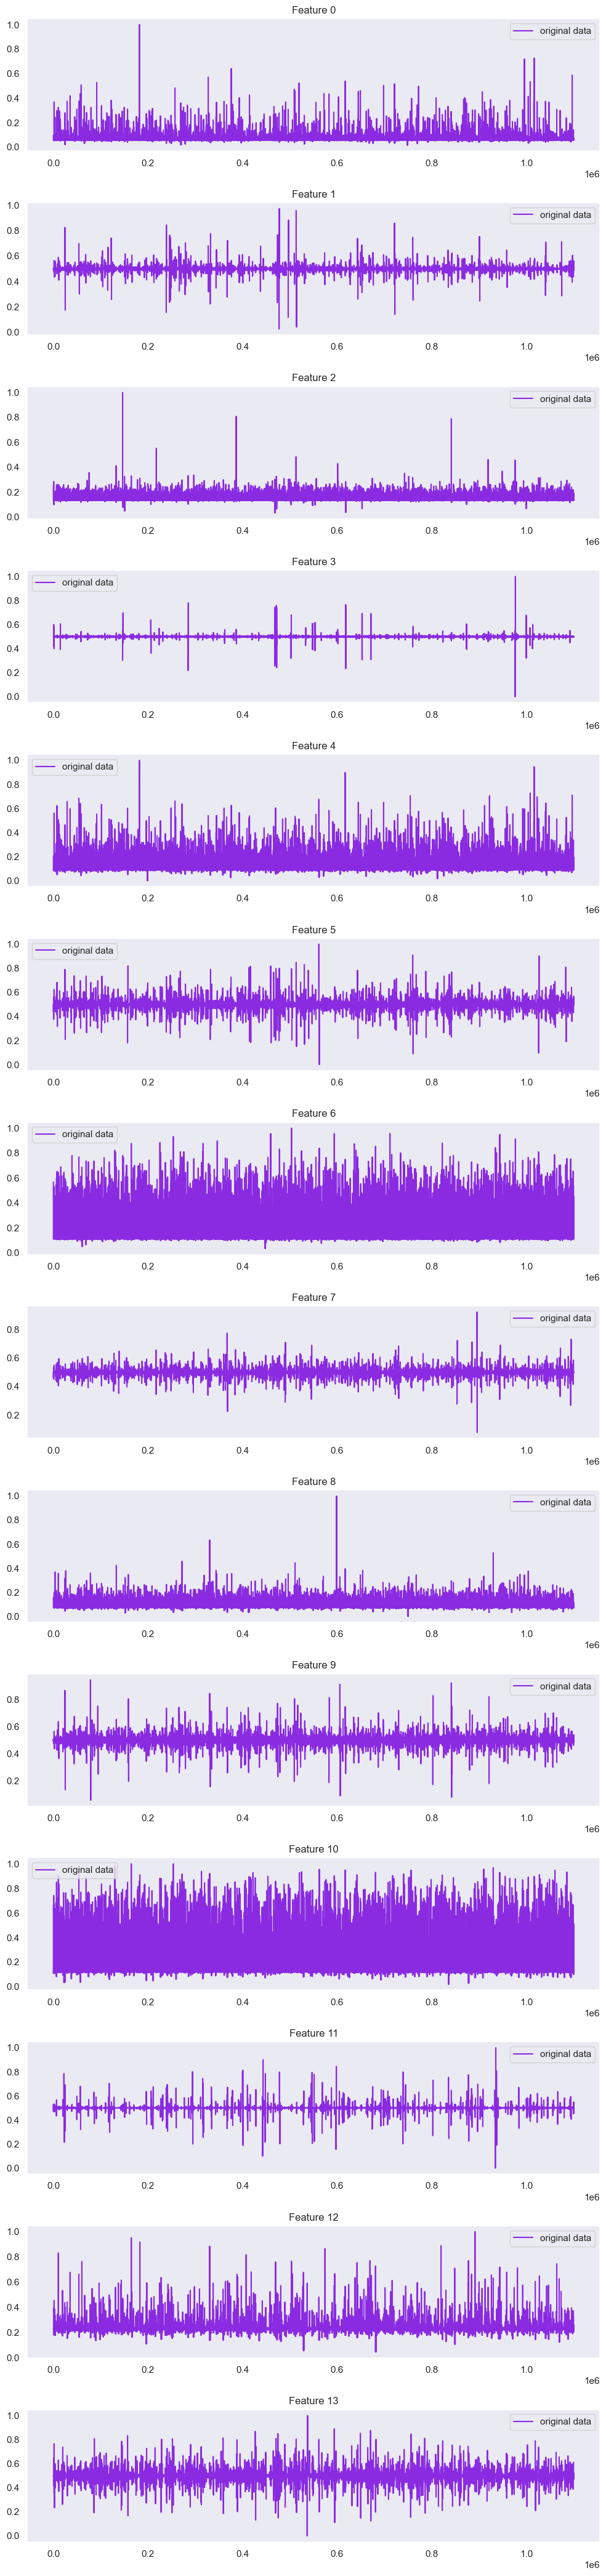

In [32]:
# 1. Извлечь данные из train_loader в виде numpy массива
train_data = []
for batch in train_loader:
    batch = batch.squeeze(1)  # убираем лишнее измерение
    batch = batch.numpy()  # преобразуем в numpy array
    for seq in batch:
        train_data.append(seq)
train_data = np.array(train_data)

# 2. Перестроить данные в подходящий формат для построения графиков
train_data = train_data.reshape(-1, seq_len, n_features)

# 3. Создать подграфики для каждой фичи
fig, axs = plt.subplots(n_features, 1, figsize=(10, n_features * 3))

# 4. Построить график для каждой фичи
for i in range(n_features):
    line, = axs[i].plot(train_data[:, 0, i], color='blueviolet', label='original data')
    for j in range(1, seq_len):
        axs[i].plot(train_data[:, j, i], color='blueviolet')
    axs[i].set_title(f'Feature {i}')
    axs[i].legend(handles=[line])  # Добавить легенду

plt.tight_layout()
plt.show()

In [33]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args('')

args.device = 'cuda' if torch.cuda.is_available() else 'cpu'

# ===== data loading ==== #
args.batch_size = 128

# ==== model capacity ==== #
args.n_layers = 1
args.embedding_dim = 128


# ==== regularization ==== #
# args.dropout = 0  # Установка значения dropout
args.use_bn = False  # batch normalization

# ==== optimizer & training  # ====
args.lr = 0.001
args.epoch = 180
args.patience = 20

In [34]:
class Encoder(nn.Module):
    def __init__(self, seq_len, n_features, args):
        super(Encoder, self).__init__()
        self.seq_len, self.n_features = seq_len, n_features
        self.hidden_dim = 2 * args.embedding_dim
        self.lstm1 = nn.LSTM(
            input_size=n_features,
            hidden_size=self.hidden_dim,
            num_layers=args.n_layers,
            batch_first=True,
            dtype=torch.float32
        ).to(args.device)
        self.lstm2 = nn.LSTM(
            input_size=self.hidden_dim,
            hidden_size=args.embedding_dim,
            num_layers=args.n_layers,
            batch_first=True,
            dtype=torch.float32
        ).to(args.device)

    def forward(self, x):
        x = x.to(args.device).to(torch.float32)
        batch_size = x.size(0)

        # print(f'ENCODER input dim: {x.shape}')
        x = x.reshape((batch_size, self.seq_len, self.n_features))
        # print(f'ENCODER reshaped dim: {x.shape}')
        x, (_, _) = self.lstm1(x)
        # print(f'ENCODER output lstm1 dim: {x.shape}')
        x, (hidden_n, _) = self.lstm2(x)
        # print(f'ENCODER output lstm2 dim: {x.shape}')
        # print(f'ENCODER hidden_n lstm2 dim: {hidden_n.shape}')
        # print(f'ENCODER hidden_n wants to be reshaped to : {(batch_size, args.embedding_dim)}')
        return hidden_n.reshape((batch_size, args.embedding_dim))

class Decoder(nn.Module):
    def __init__(self, seq_len, n_features, args):
        super(Decoder, self).__init__()
        self.seq_len, self.input_dim = seq_len, args.embedding_dim
        self.hidden_dim, self.n_features = 2 * args.embedding_dim, n_features
        self.lstm1 = nn.LSTM(
            input_size=args.embedding_dim,
            hidden_size=args.embedding_dim,
            num_layers=1,
            batch_first=True
        ).to(args.device)
        self.lstm2 = nn.LSTM(
            input_size=args.embedding_dim,
            hidden_size=self.hidden_dim,
            num_layers=1,
            batch_first=True
        ).to(args.device)
        self.output_layer = nn.Linear(self.hidden_dim, n_features).to(args.device)

    def forward(self, x):
        batch_size = x.size(0)
        x = x.to(args.device)
        # print(f'DECODER input dim: {x.shape}')
        x = x.repeat_interleave(self.seq_len, dim=0)
        # print(f'DECODER repeat dim: {x.shape}')
        x = x.reshape((batch_size, self.seq_len, self.input_dim))
        # print(f'DECODER reshaped dim: {x.shape}')
        x, (hidden_n, cell_n) = self.lstm1(x)
        # print(f'DECODER output rnn1 dim:/ {x.shape}')
        x, (hidden_n, cell_n) = self.lstm2(x)
        x = x.reshape((batch_size, self.seq_len, self.hidden_dim))
        return self.output_layer(x)

class LSTM_AUTO_ENCODER(nn.Module):
    def __init__(self, seq_len, n_features, args):
        super(LSTM_AUTO_ENCODER, self).__init__()
        self.seq_len = seq_len
        self.n_features = n_features
        self.encoder = Encoder(seq_len, n_features, args)
        self.decoder = Decoder(seq_len, n_features, args)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [35]:
class EarlyStopping:
    def __init__(self, patience=20, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

Проверка работоспособности модели

In [36]:
# encoder = Encoder(seq_len, n_features)

# for batch in train_loader:
#     output = encoder(batch)
#     print(f'Input shape: {batch.shape}')
#     print(f'Output shape: {output.shape}')
#     print('-' * 30)


In [37]:
# decoder = Decoder(seq_len, n_features)

# for batch in train_loader:
#     input_tensor = torch.randn(batch.size(0), args.embedding_dim)  # Создаем случайный входной тензор для декодера
#     output = decoder(input_tensor)
#     print(f'Input shape: {input_tensor.shape}')
#     print(f'Output shape: {output.shape}')
#     print('-' * 30)
#     break  # Выходим из цикла после первой итерации

In [38]:
# model = LSTM_AUTO_ENCODER(seq_len, n_features, args)

# for batch in train_loader:
#     input_tensor = batch
#     output = model(input_tensor)
#     print(f'Input shape: {input_tensor.shape}')
#     print(f'Output shape: {output.shape}')
#     print('-' * 30)
#     break

In [39]:
def train_model(model,train_loader, val_loader, n_epochs, n_features, args):
    early_stopping = EarlyStopping(patience=args.patience)
    # Установка режима обучения
    model.train()
    
    # Оптимизатор и функция потерь
    optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
    criterion = nn.MSELoss(reduction='sum').to(args.device)

    # История обучения
    history = {'train': [], 'val': []}

    # Переменная для отслеживания лучшей модели
    best_model_wts = None
    best_val_loss = float('inf')

    # Цикл обучения
    for epoch in range(1, n_epochs + 1):
        model = model.train()
        ts = time.time()
        train_losses = []

        # Создание DataLoader для обучающего набора данных
        train_loader = DataLoader(train_data, batch_size=args.batch_size, shuffle=False)
        train_loader = tqdm(train_loader, desc=f'Epoch {epoch}', leave=False)

        for seq_true in train_loader:
            optimizer.zero_grad()

            # Изменение формы входных данных на (batch_size, seq_len, n_features)
            seq_true = seq_true.reshape((-1, seq_len, n_features))
            seq_true = seq_true.float().to(args.device)

            seq_pred = model(seq_true)
    
            loss = criterion(seq_pred, seq_true)
            
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())
            # Обновление tqdm
            train_loader.set_postfix(train_loss=np.mean(train_losses))

        val_losses = []
        model = model.eval()
        with torch.no_grad():
            for seq_true in val_loader:

                # Изменение формы входных данных на (batch_size, seq_len, n_features)
                seq_true = seq_true.reshape((-1, seq_len, n_features))
                seq_true = seq_true.float().to(args.device)

                seq_pred = model(seq_true)

                loss = criterion(seq_pred, seq_true)

                val_losses.append(loss.item())
        te = time.time()
        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)
        history['train'].append(train_loss)
        history['val'].append(val_loss)
        
        # Вызов EarlyStopping и проверка на необходимость остановки
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print(f"Early stopping at epoch {epoch}")
            break
        
        print(f"Epoch: {epoch}  train loss: {train_loss}  val loss: {val_loss}  time: {te-ts} ")
        # Построение графиков каждые 10 эпох
        if epoch % 10 == 0:
            # 1. Извлечь данные из val_loader в виде numpy массива
            val_data_np = torch.cat([batch for batch in val_loader], dim=0).detach().cpu().numpy()

            # 2. Перестроить данные в подходящий формат для построения графиков
            val_data_np = val_data_np.reshape(-1, seq_len, n_features)

            # 3. Получить предсказания модели
            preds = []
            with torch.no_grad():
                model = model.eval()
                for seq_true in val_loader:
                    seq_true = seq_true.to(args.device)
                    seq_true = seq_true.reshape((-1, seq_len, n_features))

                    seq_pred = model(seq_true)
                    preds.append(seq_pred.cpu().numpy())
            preds = np.concatenate(preds, axis=0)

            # 4. Создать подграфики для каждой фичи
            fig, axs = plt.subplots(n_features, 1, figsize=(10, n_features * 3))

            # 5. Построить график для каждой фичи
            for i in range(n_features):
                line1, = axs[i].plot(val_data_np[:, 0, i], color='blueviolet', label='original data')

                line2, = axs[i].plot(preds[:, 0, i], color='orange', label='predictions')
                for j in range(1, seq_len):
                    axs[i].plot(val_data_np[:, j, i], color='blueviolet')
                    axs[i].plot(preds[:, j, i], color='orange')
                axs[i].set_title(f'Feature {i}')
                axs[i].legend(handles=[line1, line2])

            plt.tight_layout()
            plt.show()

        # Сохранение лучшей модели
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())

    # Загрузка весов лучшей модели
    model.load_state_dict(best_model_wts)

    return model.eval(), history


In [40]:
model = LSTM_AUTO_ENCODER(seq_len=seq_len, n_features=n_features, args=args)
model = model.to(args.device)
model

LSTM_AUTO_ENCODER(
  (encoder): Encoder(
    (lstm1): LSTM(14, 256, batch_first=True)
    (lstm2): LSTM(256, 128, batch_first=True)
  )
  (decoder): Decoder(
    (lstm1): LSTM(128, 128, batch_first=True)
    (lstm2): LSTM(128, 256, batch_first=True)
    (output_layer): Linear(in_features=256, out_features=14, bias=True)
  )
)

Epoch: 1  train loss: 0.49289064596810844  val loss: 0.05802747521831026  time: 87.92321372032166 


Epoch: 2  train loss: 0.03172511858416878  val loss: 0.05346661758154284  time: 83.40528082847595 


Epoch: 3  train loss: 0.024122487603562212  val loss: 0.028854037375990734  time: 86.00239682197571 


Epoch: 4  train loss: 0.0174516837458332  val loss: 0.022679227322751527  time: 84.89286756515503 


Epoch: 5  train loss: 0.013998702669991342  val loss: 0.022647462733046606  time: 85.63345265388489 


Epoch: 6  train loss: 0.012079402454979826  val loss: 0.020778867238807643  time: 86.00145077705383 


Epoch: 7  train loss: 0.01080387133617224  val loss: 0.015582943527504455  time: 86.73388767242432 


Epoch: 8  train loss: 0.008957903223333211  val loss: 0.013576002873881006  time: 85.90018701553345 


Epoch: 9  train loss: 0.008476974780358982  val loss: 0.01785495444493325  time: 86.46349549293518 


Epoch: 10  train loss: 0.0077842752243981695  val loss: 0.019524051437132754  time: 86.50478100776672 


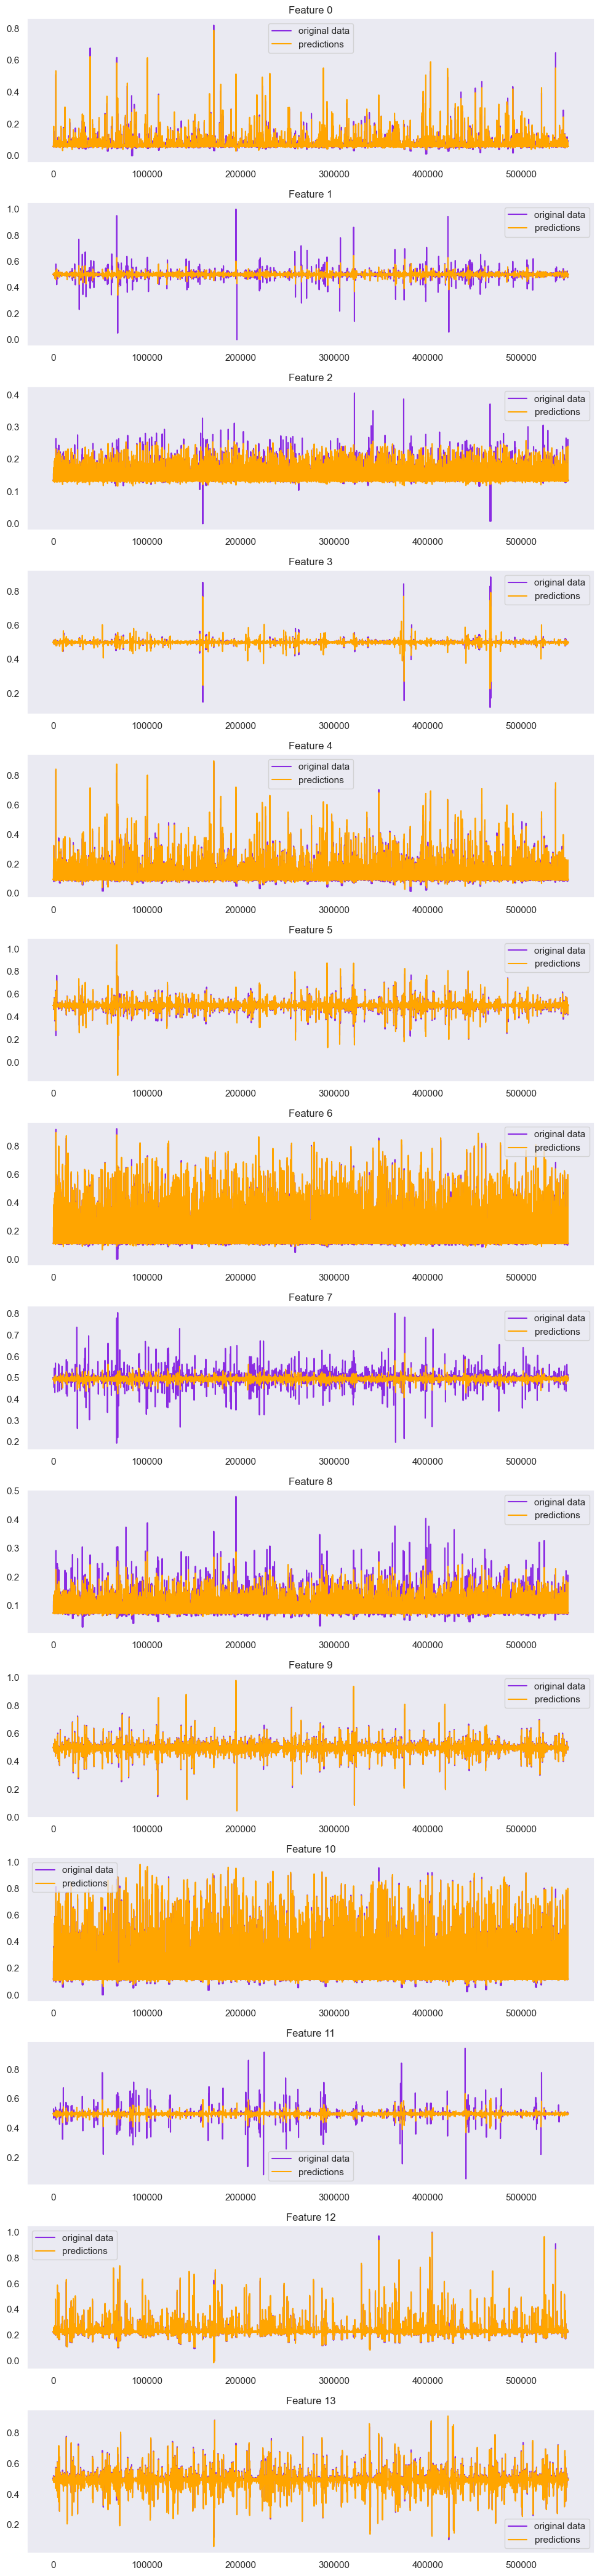

Epoch: 11  train loss: 0.006551657076425028  val loss: 0.013870410608929084  time: 99.42058777809143 


Epoch: 12  train loss: 0.005567159108920117  val loss: 0.012384033815848619  time: 90.21279573440552 


Epoch: 13  train loss: 0.00517244976033527  val loss: 0.012795824918376152  time: 84.64785504341125 


Epoch: 14  train loss: 0.00415947621904368  val loss: 0.01109854939881019  time: 84.99574494361877 


Epoch: 15  train loss: 0.0036463231067242557  val loss: 0.010317476636535207  time: 85.29783535003662 


Epoch: 16  train loss: 0.003578693189287743  val loss: 0.006332050676804123  time: 85.12898683547974 


Epoch: 17  train loss: 0.003155353869471244  val loss: 0.01172791573468076  time: 86.28053593635559 


Epoch: 18  train loss: 0.0029922477384181634  val loss: 0.008405399718863326  time: 85.38641166687012 


Epoch: 19  train loss: 0.002959878476959962  val loss: 0.019171453284446235  time: 85.43773865699768 


Epoch: 20  train loss: 0.0025228700425082764  val loss: 0.020408659768832285  time: 85.9323205947876 


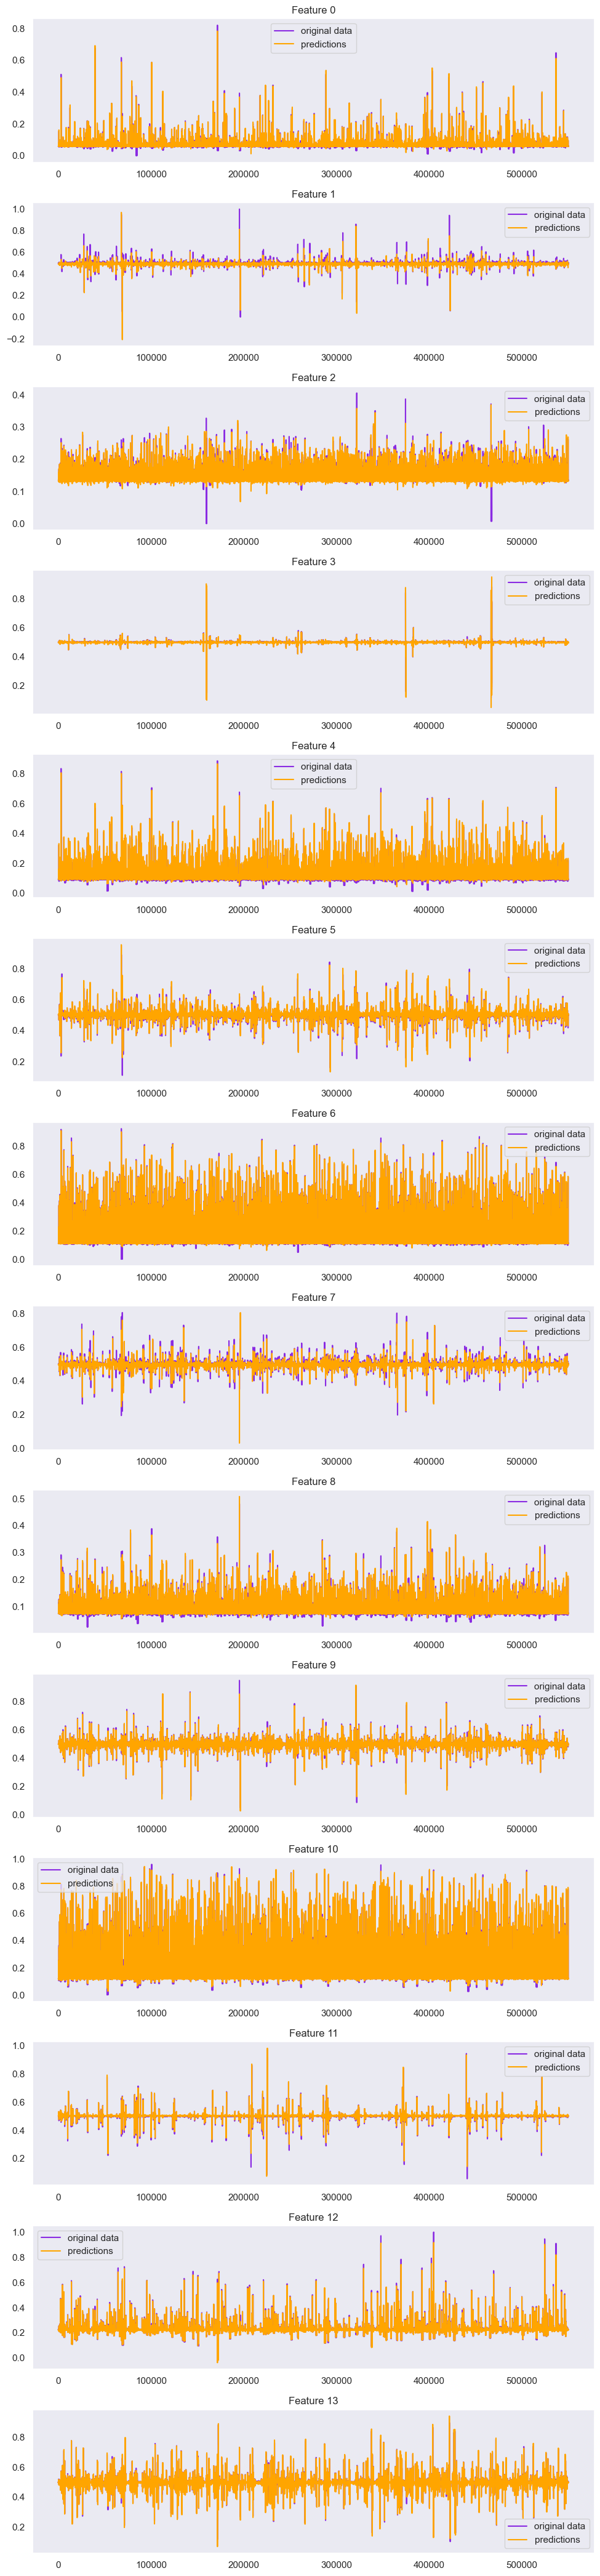

Epoch: 21  train loss: 0.002279180480491473  val loss: 0.014103365269554562  time: 86.2314567565918 


Epoch: 22  train loss: 0.0018250180064899532  val loss: 0.004710795562443605  time: 85.3260338306427 


Epoch: 23  train loss: 0.0016610716402630165  val loss: 0.005761391806556995  time: 85.60391283035278 


Epoch: 24  train loss: 0.0013856251878806413  val loss: 0.00393235502418044  time: 85.70980310440063 


Epoch: 25  train loss: 0.0012948979491715744  val loss: 0.002522334969063766  time: 85.53658866882324 


Epoch: 26  train loss: 0.0011414883740937596  val loss: 0.0038665300244357177  time: 85.59764218330383 


Epoch: 27  train loss: 0.0010128766283549677  val loss: 0.0020576040639655752  time: 85.58137273788452 


Epoch: 28  train loss: 0.0010670814360639988  val loss: 0.0024739730300728318  time: 85.55484342575073 


Epoch: 29  train loss: 0.0009042895560987534  val loss: 0.0019897182640175575  time: 85.95944094657898 


Epoch: 30  train loss: 0.0008634026588238475  val loss: 0.002731450562484476  time: 86.05985116958618 


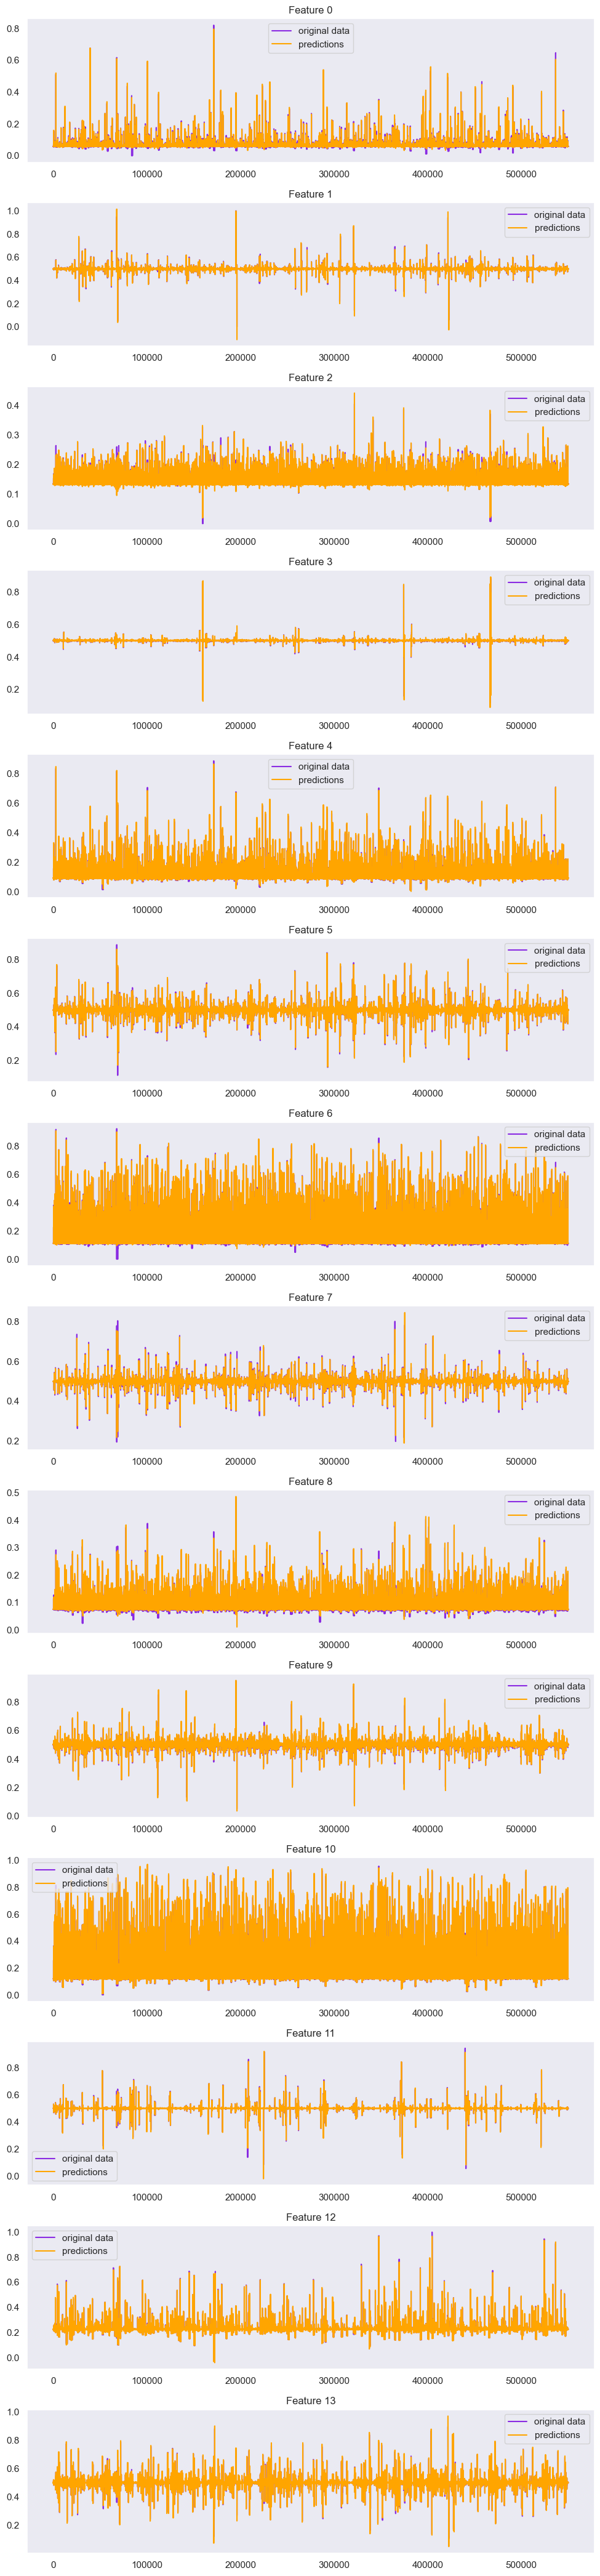

Epoch: 31  train loss: 0.0008527798171133666  val loss: 0.006280041242040001  time: 85.84507632255554 


Epoch: 32  train loss: 0.0007471584770887285  val loss: 0.006261546699720066  time: 85.16593861579895 


Epoch: 33  train loss: 0.0007283172739196447  val loss: 0.0016407623390401823  time: 85.14202737808228 


Epoch: 34  train loss: 0.0007288917741498364  val loss: 0.0032234406117945475  time: 85.54376935958862 


Epoch: 35  train loss: 0.0006574048132396519  val loss: 0.0014900663958017737  time: 85.26761531829834 


Epoch: 36  train loss: 0.0006643192160948084  val loss: 0.00275555953849107  time: 85.45814847946167 


Epoch: 37  train loss: 0.0006872163371146894  val loss: 0.002657523048597626  time: 85.71089768409729 


Epoch: 38  train loss: 0.0006351082574167586  val loss: 0.002892454396283557  time: 87.68569684028625 


Epoch: 39  train loss: 0.0005673264142056765  val loss: 0.001123270658345698  time: 85.54592657089233 


Epoch: 40  train loss: 0.0006393226647078654  val loss: 0.0020588106288423023  time: 85.81774616241455 


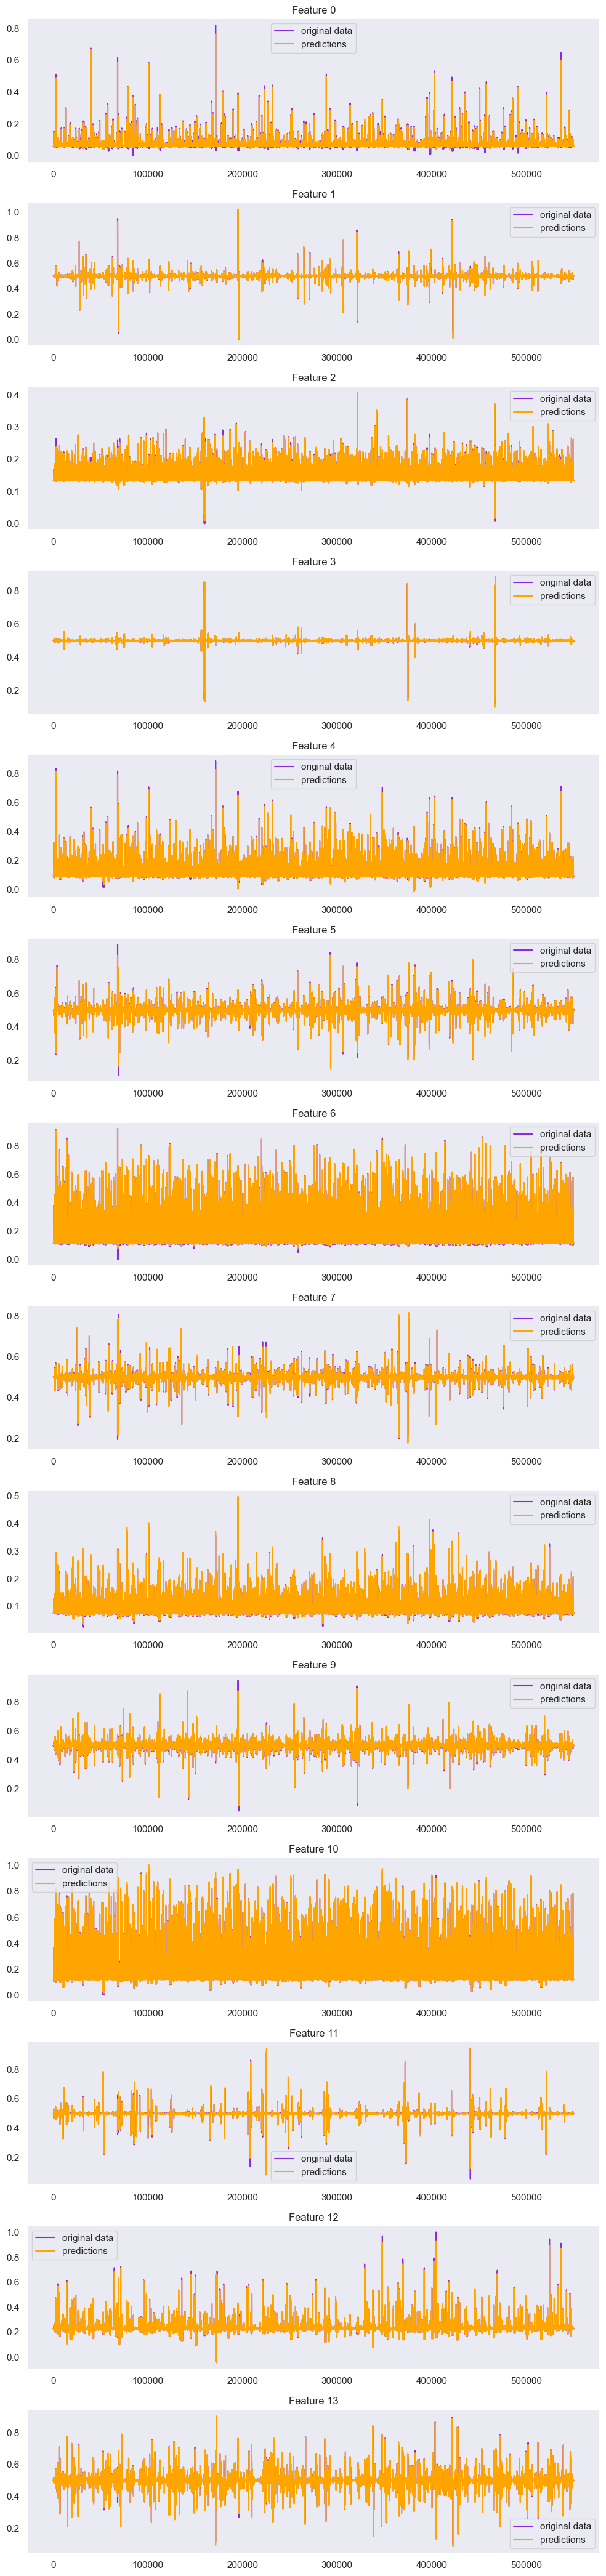

Epoch: 41  train loss: 0.0005449883851267873  val loss: 0.002324901370217937  time: 86.09755182266235 


Epoch: 42  train loss: 0.0005935991137592938  val loss: 0.0029639292705999037  time: 85.7854015827179 


Epoch: 43  train loss: 0.0005663474910424748  val loss: 0.001749704776475271  time: 85.73792004585266 


Epoch: 44  train loss: 0.0005120885190877363  val loss: 0.0013278217825410498  time: 85.68151497840881 


Epoch: 45  train loss: 0.0005525150589000247  val loss: 0.0017974935018668645  time: 85.82554769515991 


Epoch: 46  train loss: 0.0005274695551860912  val loss: 0.0016498399861860848  time: 87.20094847679138 


Epoch: 47  train loss: 0.0005305576010488399  val loss: 0.001827004146288409  time: 85.79869484901428 


Epoch: 48  train loss: 0.00047994290594170855  val loss: 0.0010370928509469512  time: 86.00672793388367 


Epoch: 49  train loss: 0.0004448110104363497  val loss: 0.0025686154998622317  time: 85.68150901794434 


Epoch: 50  train loss: 0.00046770282253059714  val loss: 0.0016541162738305797  time: 86.39482474327087 


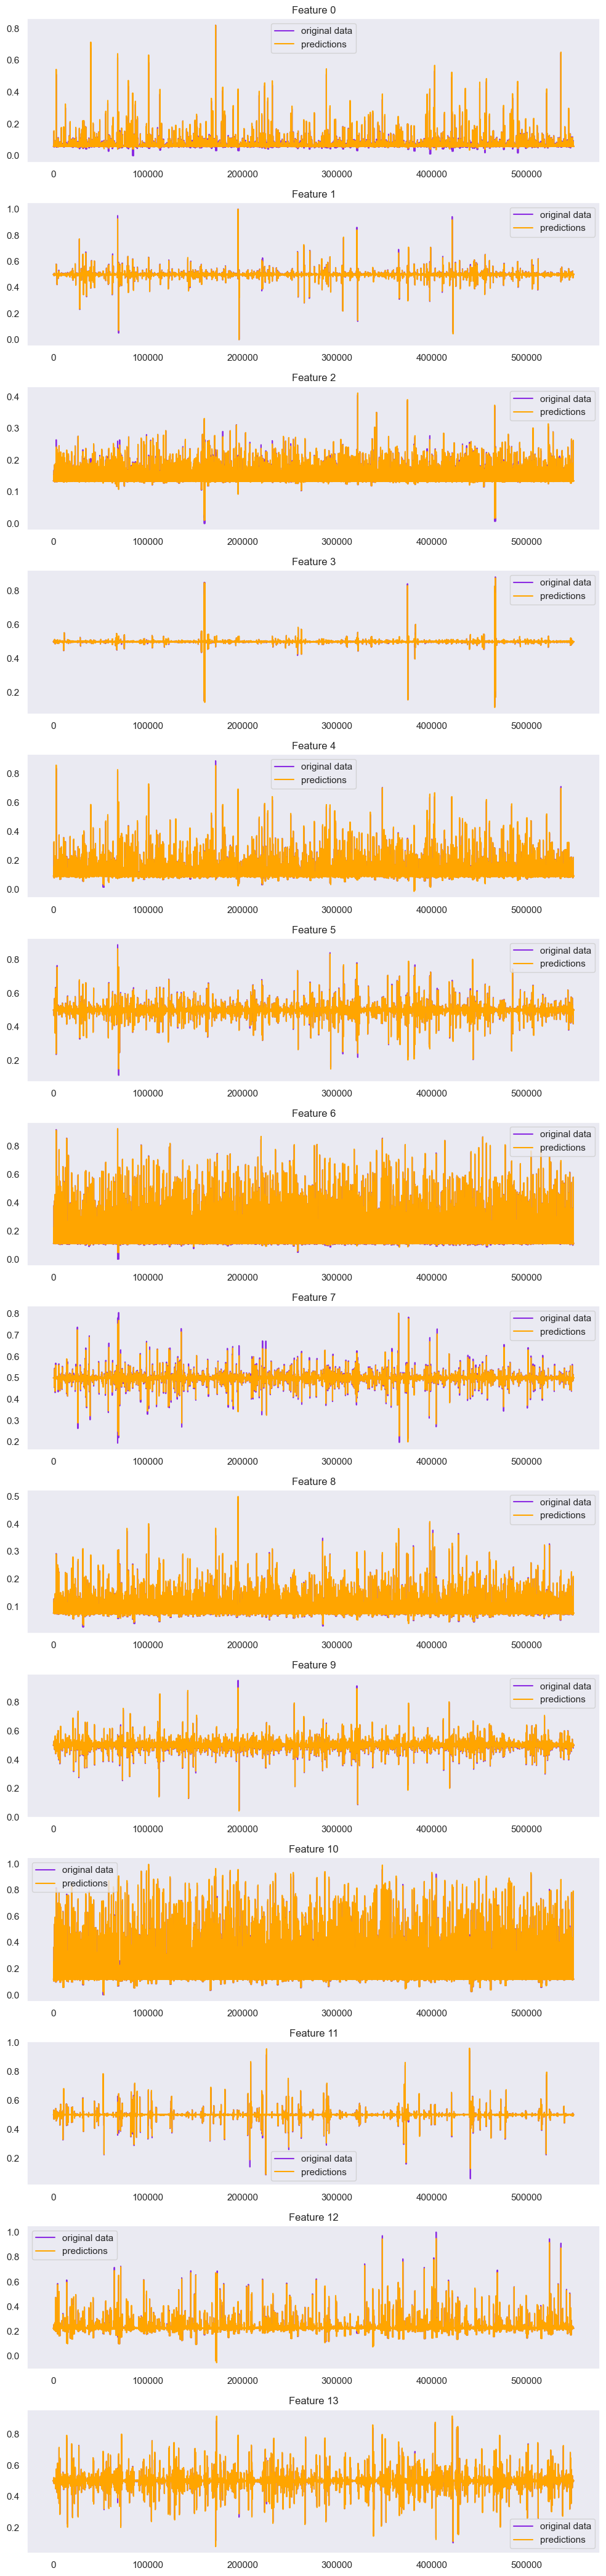

Epoch: 51  train loss: 0.0004266799063202069  val loss: 0.00238790231545694  time: 86.33388566970825 


Epoch: 52  train loss: 0.0004786703340384922  val loss: 0.002128559680747648  time: 85.60891771316528 


Epoch: 53  train loss: 0.0004225798820211927  val loss: 0.0024728044127330703  time: 85.75321435928345 


Epoch: 54  train loss: 0.00044533743859299354  val loss: 0.0038934351017070544  time: 85.73740363121033 


Epoch: 55  train loss: 0.0004239327338157023  val loss: 0.0020042094223060494  time: 85.80767774581909 


Epoch: 56  train loss: 0.0003769385519649404  val loss: 0.0018769470567213979  time: 86.0424690246582 


Epoch: 57  train loss: 0.0003999854632131912  val loss: 0.001463192438051581  time: 86.10393571853638 


Epoch: 58  train loss: 0.0004835708376707623  val loss: 0.0025783509499025204  time: 86.10494780540466 


Epoch: 59  train loss: 0.0003901691215240896  val loss: 0.0010263230348801847  time: 85.85347962379456 


Epoch: 60  train loss: 0.00036141931812814387  val loss: 0.0021275368740045746  time: 86.7479259967804 


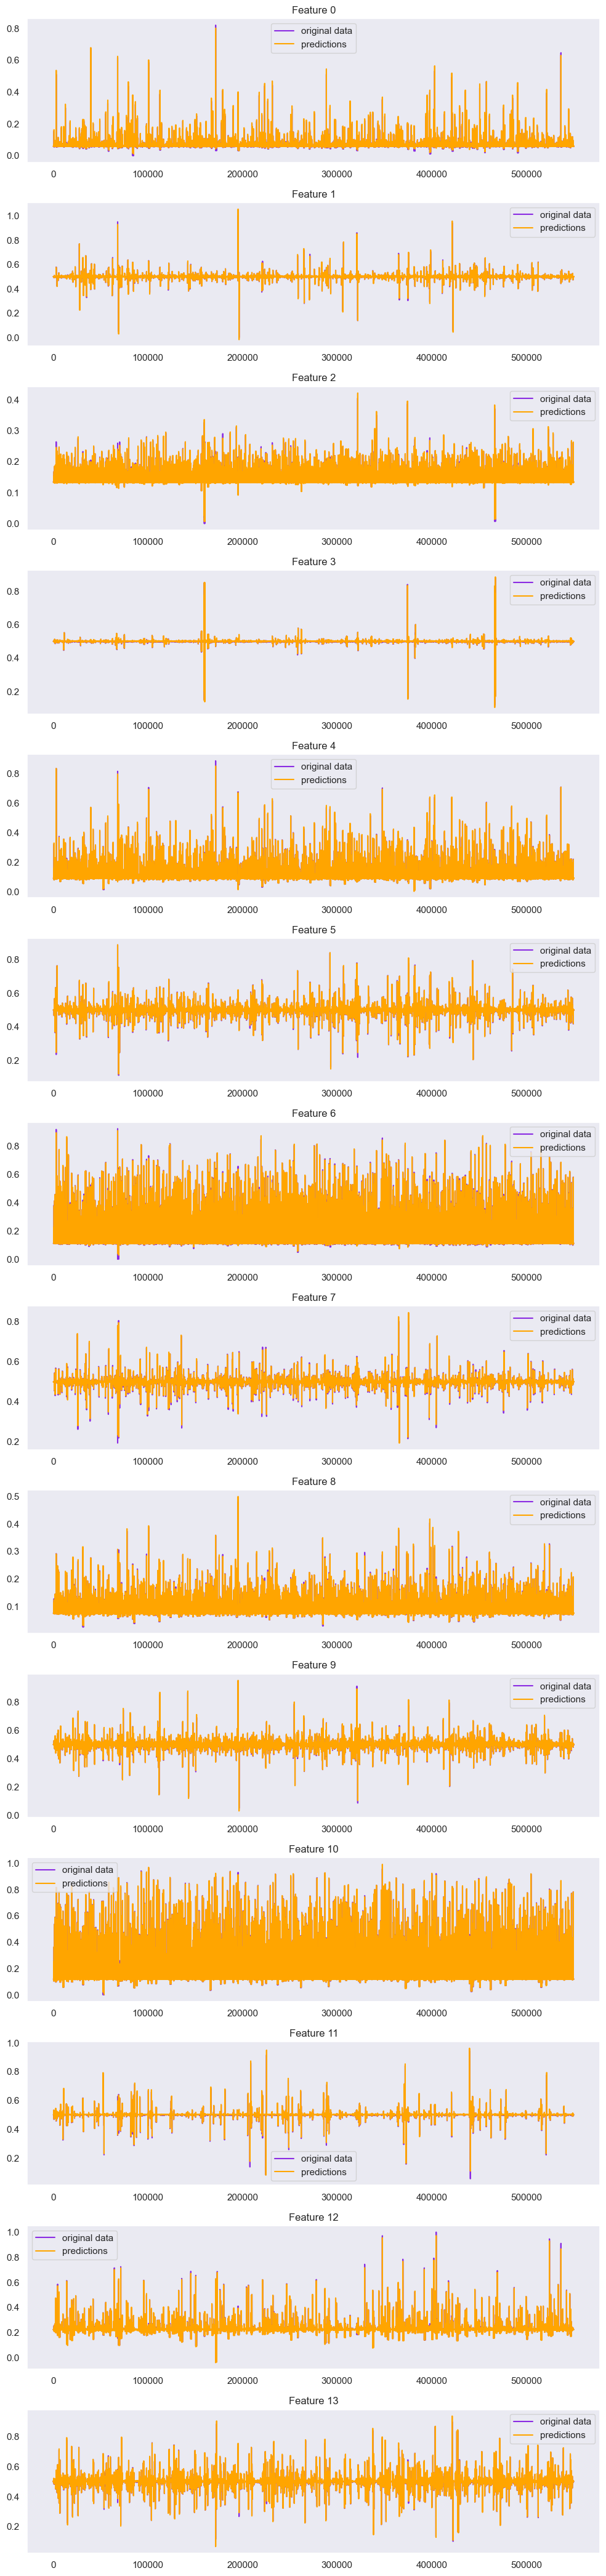

Epoch: 61  train loss: 0.00037277110187301863  val loss: 0.0007030578379026549  time: 87.31125330924988 


Epoch: 62  train loss: 0.0003371498686171731  val loss: 0.0022215247600675062  time: 94.61706113815308 


Epoch: 63  train loss: 0.0003932779223114372  val loss: 0.0015424410102558648  time: 105.899573802948 


Epoch: 64  train loss: 0.00041141614484175524  val loss: 0.0015823250247414635  time: 88.41739463806152 


Epoch: 65  train loss: 0.0003203362704445765  val loss: 0.0016494584010459136  time: 86.50314021110535 


Epoch: 66  train loss: 0.0003561240637733072  val loss: 0.0007521308015295586  time: 86.91779255867004 


Epoch: 67  train loss: 0.0003270012833001924  val loss: 0.0005858908175777774  time: 86.78892421722412 


Epoch: 68  train loss: 0.0003316200579344462  val loss: 0.001074461923346335  time: 87.06312680244446 


Epoch: 69  train loss: 0.0003145450654361665  val loss: 0.0012743654718005294  time: 87.16317796707153 


Epoch: 70  train loss: 0.00039049876375685905  val loss: 0.0013536232167335098  time: 87.53674268722534 


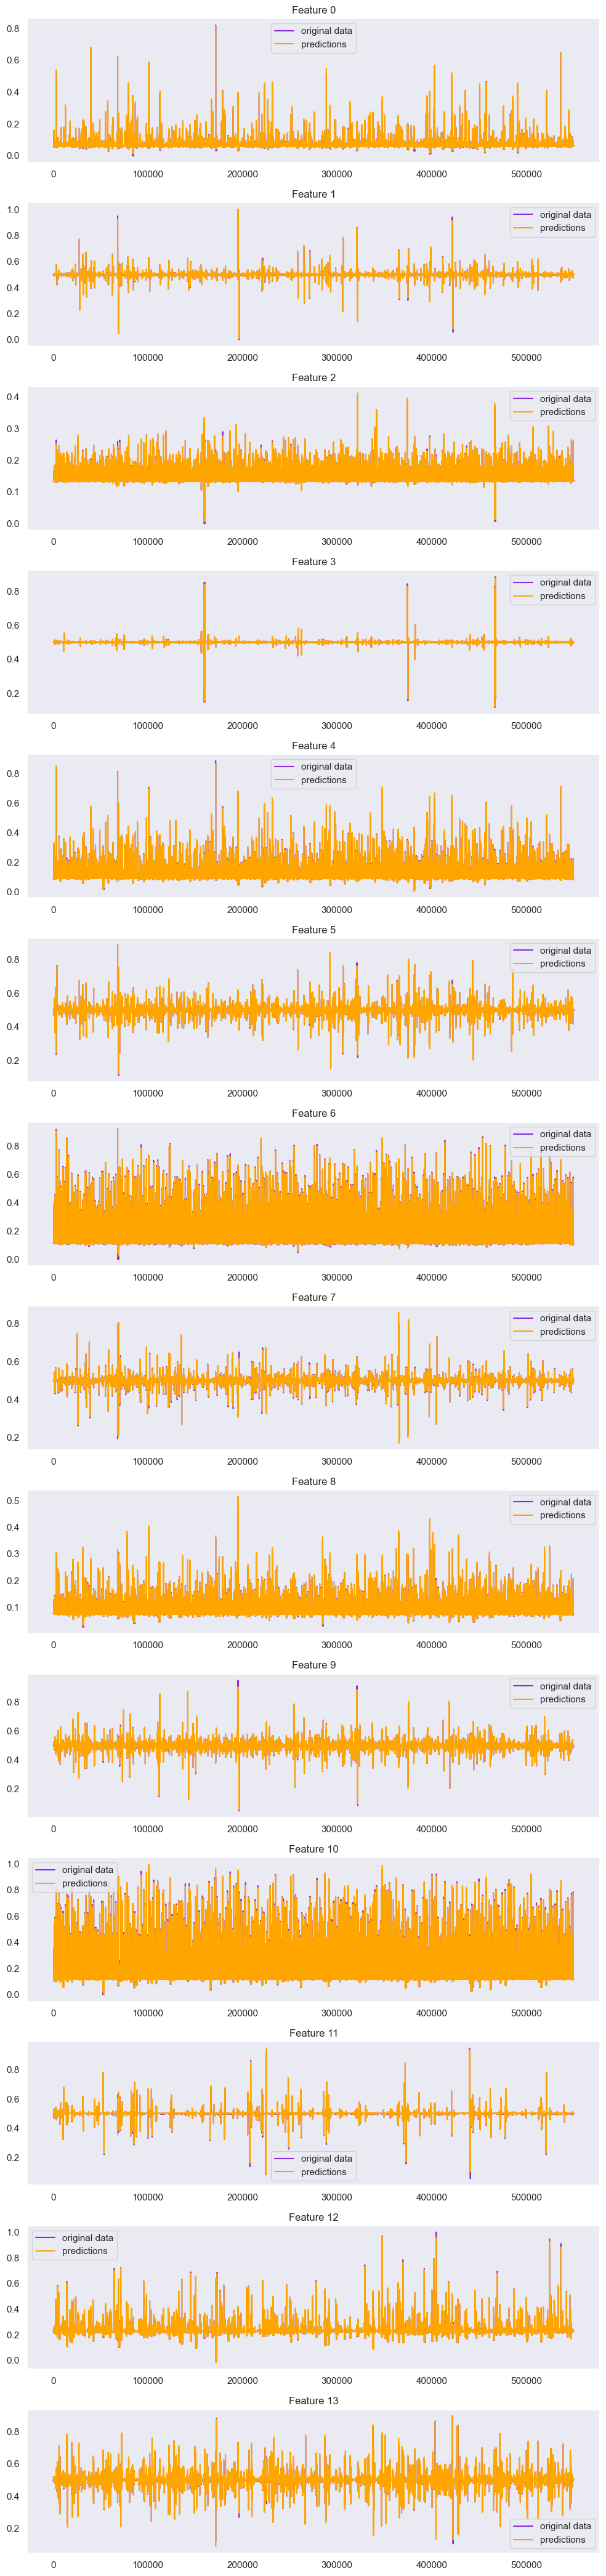

Epoch: 71  train loss: 0.0002997677515211202  val loss: 0.0006223755360440199  time: 86.65824961662292 


Epoch: 72  train loss: 0.00033235829798672437  val loss: 0.0013716594927381117  time: 85.75590372085571 


Epoch: 73  train loss: 0.00031669078772900974  val loss: 0.0008036368028098328  time: 85.91847395896912 


Epoch: 74  train loss: 0.00031805637559035286  val loss: 0.0006589347282207982  time: 86.17091679573059 


Epoch: 75  train loss: 0.00028697359915200166  val loss: 0.001543280624359478  time: 86.1392982006073 


Epoch: 76  train loss: 0.00029632086461978634  val loss: 0.0009852913238357233  time: 86.40535879135132 


Epoch: 77  train loss: 0.0003004066723757512  val loss: 0.0007585660564688815  time: 87.29950761795044 


Epoch: 78  train loss: 0.00029343583870984223  val loss: 0.00017743898053849144  time: 86.47430062294006 


Epoch: 79  train loss: 0.00029546111951091474  val loss: 0.003207720901010298  time: 86.29229497909546 


Epoch: 80  train loss: 0.00028111611111971216  val loss: 0.001017763112254744  time: 87.18812274932861 


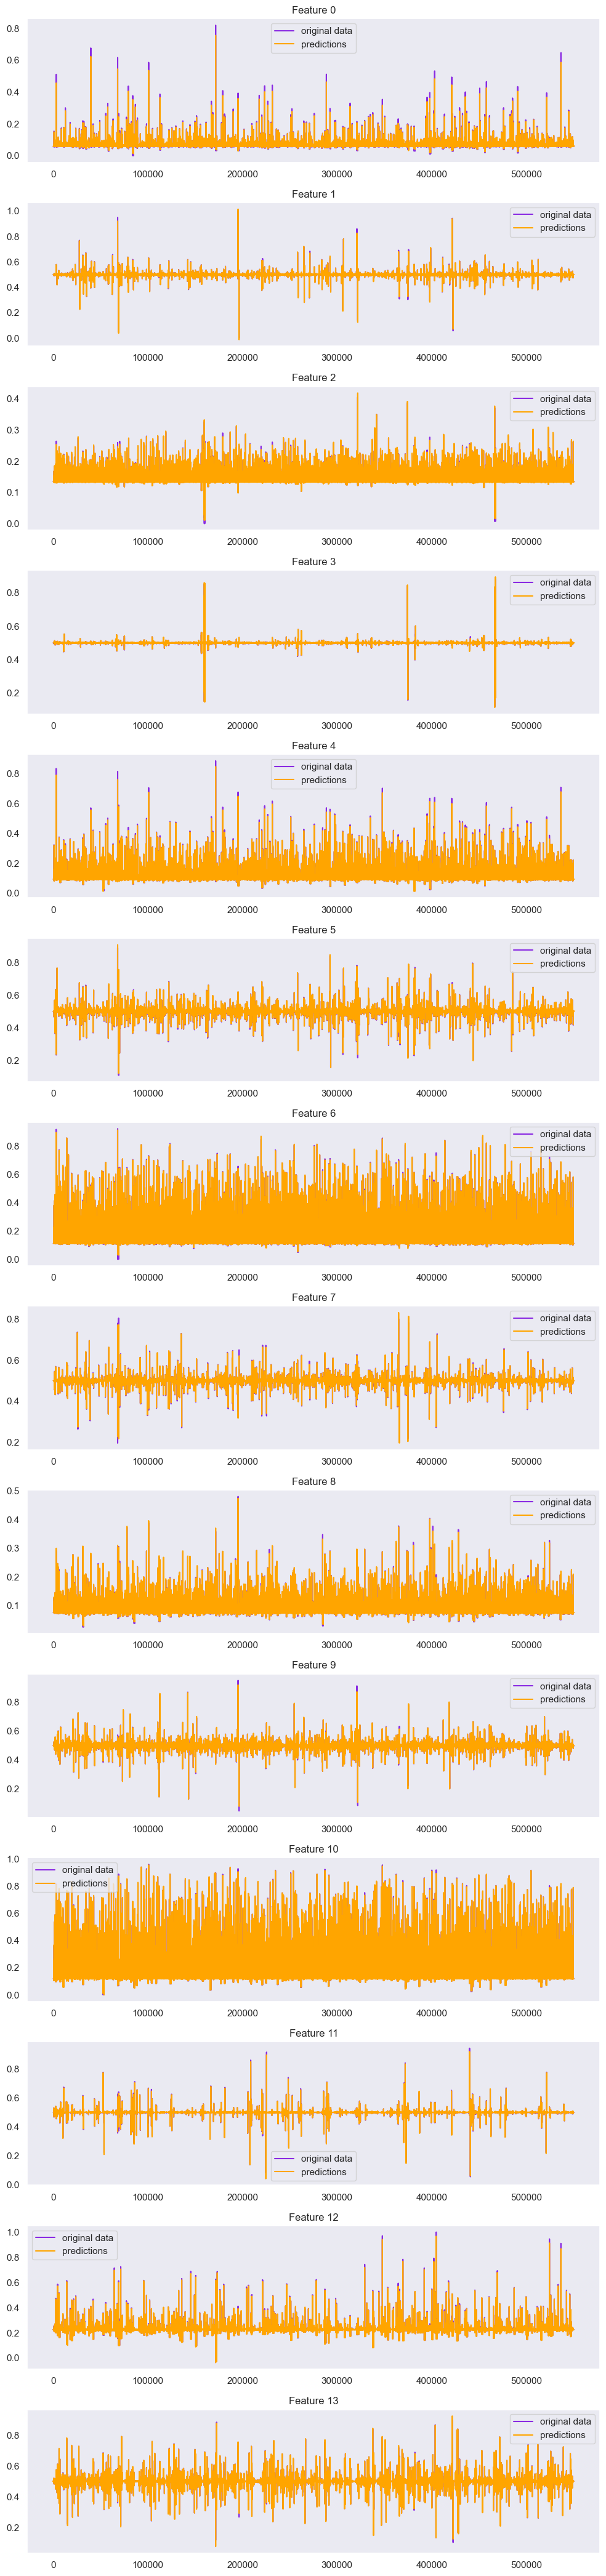

Epoch: 81  train loss: 0.00032708417666970827  val loss: 0.0013934951757492368  time: 86.73852252960205 


Epoch: 82  train loss: 0.00027015402467652676  val loss: 0.0006446162515812619  time: 86.20930814743042 


Epoch: 83  train loss: 0.0003071745889975202  val loss: 0.0021492175659879524  time: 86.01181888580322 


Epoch: 84  train loss: 0.0002837617799754917  val loss: 0.0013626681805214693  time: 87.68030548095703 


Epoch: 85  train loss: 0.0002640225467098918  val loss: 0.0002030719229870281  time: 86.47396302223206 


Epoch: 86  train loss: 0.00027022061248301325  val loss: 0.0007901960977510181  time: 86.27700638771057 


Epoch: 87  train loss: 0.00028047116814914366  val loss: 0.0018675279230431676  time: 86.36645078659058 


Epoch: 88  train loss: 0.00027851363321929057  val loss: 0.0021884582598076397  time: 86.52476525306702 


Epoch: 89  train loss: 0.0002961461552117567  val loss: 0.0011557105808453851  time: 86.37554144859314 


Epoch: 90  train loss: 0.00026480670006157894  val loss: 0.0006564235867428875  time: 86.98439502716064 


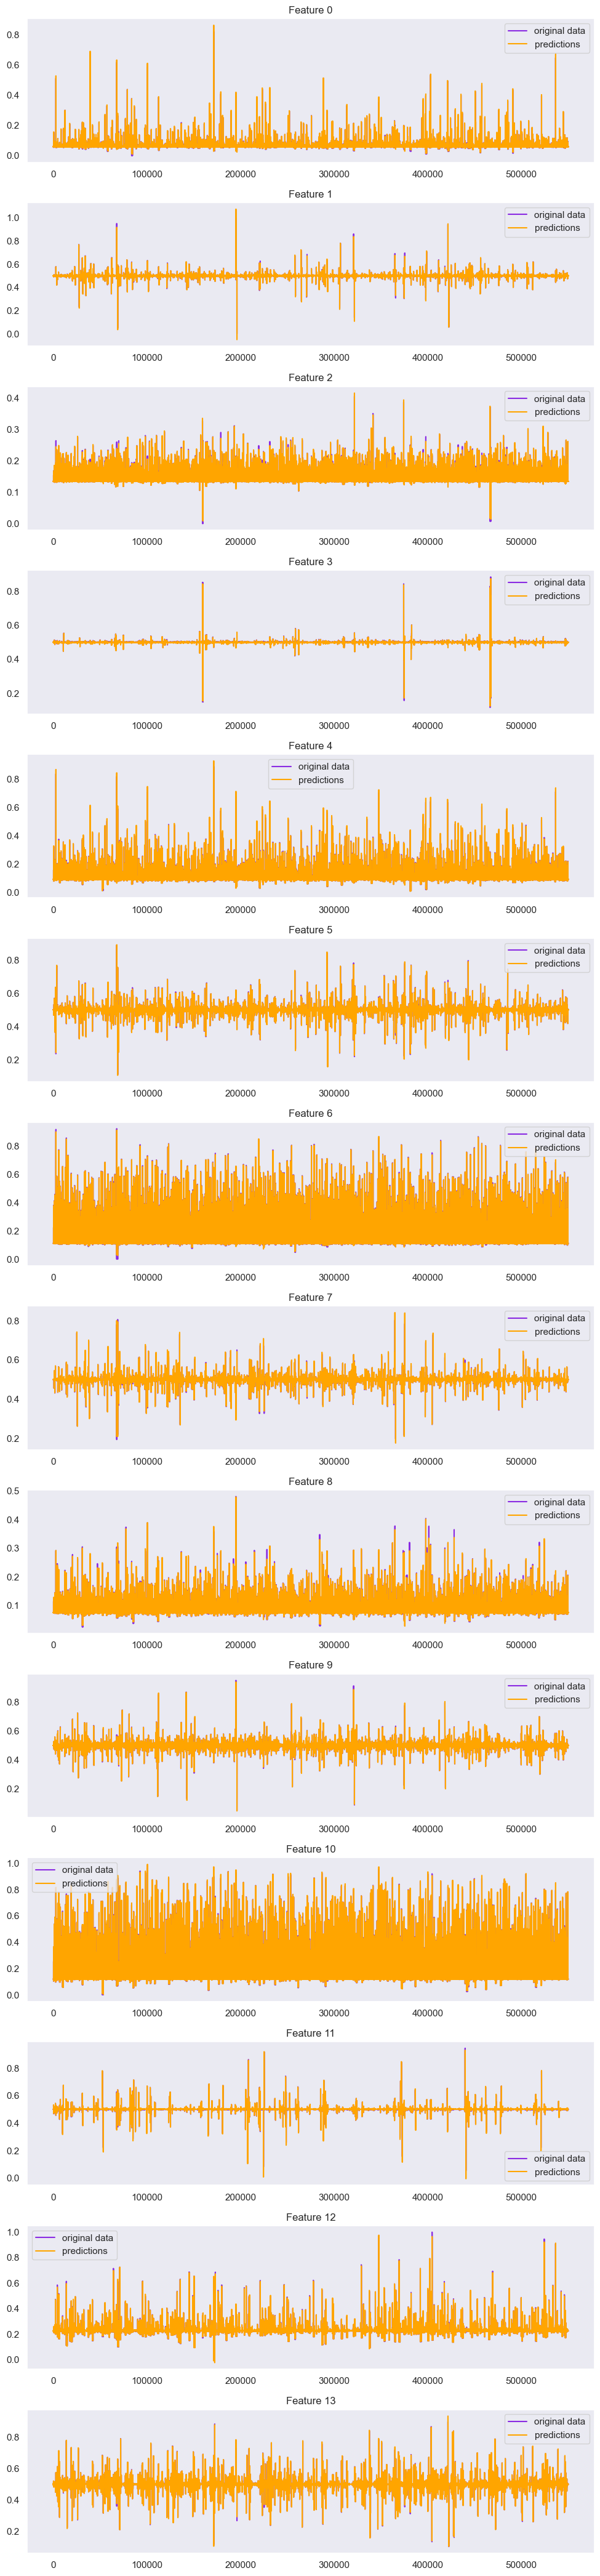

Epoch: 91  train loss: 0.0002667076378047251  val loss: 0.00048040097733677994  time: 86.54930090904236 


Epoch: 92  train loss: 0.000263183458063194  val loss: 0.0003160345311064089  time: 86.24603986740112 


Epoch: 93  train loss: 0.0002596673007698835  val loss: 0.0008269685001293912  time: 86.18816757202148 


Epoch: 94  train loss: 0.0002833234187465773  val loss: 0.0009103621175745502  time: 86.29521656036377 


Epoch: 95  train loss: 0.0002804949524386038  val loss: 0.00045477129305106435  time: 86.45425224304199 


Epoch: 96  train loss: 0.00026519327678606926  val loss: 0.0004865086797643778  time: 93.15432691574097 


Epoch: 97  train loss: 0.00024861902657874474  val loss: 0.0006900074771337406  time: 86.70257306098938 


Early stopping at epoch 98


In [41]:
model, history = train_model(model, train_loader,val_loader , args.epoch, n_features, args)

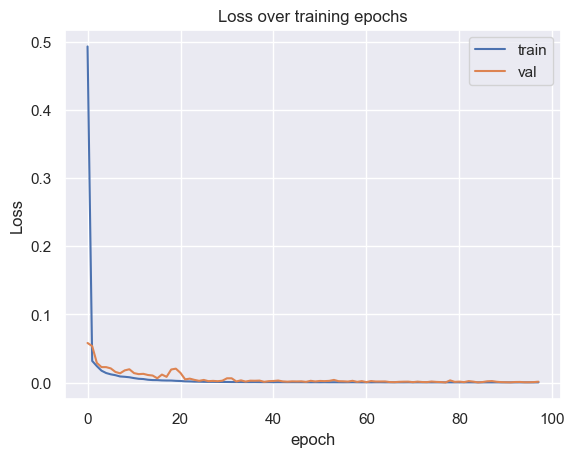

In [43]:
sns.set(style='dark')
plt.plot(history['train'])
plt.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('epoch')
# plt.ylim(0, 1)
plt.title('Loss over training epochs')
plt.legend(['train','val'])
plt.grid()
plt.savefig('losses_new.png', dpi=300)
plt.show();

In [44]:
MODEL_PATH = 'lstmae_v1.1.pth'
torch.save(model, MODEL_PATH)

In [45]:
model = torch.load('lstmae_v1.1.pth')
model = model.to(args.device)
model

LSTM_AUTO_ENCODER(
  (encoder): Encoder(
    (lstm1): LSTM(14, 256, batch_first=True)
    (lstm2): LSTM(256, 128, batch_first=True)
  )
  (decoder): Decoder(
    (lstm1): LSTM(128, 128, batch_first=True)
    (lstm2): LSTM(128, 256, batch_first=True)
    (output_layer): Linear(in_features=256, out_features=14, bias=True)
  )
)

In [46]:
class Create_dataset(Dataset):
    def __init__(self, data, seq_len=1, batch_size=1):
        self.data = data
        self.seq_len = seq_len
        self.batch_size = batch_size
        self.n_samples, self.n_features = self.data.shape
        self.dataset = self.create_dataset(self.data, batch_size)

    def create_dataset(self, data, batch_size):
        sequences = []
        for i in range(len(data) - self.seq_len + 1):
            sequence = data.iloc[i:i+self.seq_len].values.astype(np.float32)
            sequences.append(torch.from_numpy(sequence))
        return DataLoader(sequences, batch_size=batch_size, shuffle=False)

    def __getitem__(self, index):
        return self.data.iloc[index]

    def __len__(self):
        return len(self.data) - self.seq_len + 1

In [55]:
class encdataset(Dataset):
    def __init__(self, data, seq_len=1, batch_size=1):
        # data load
        self.data = data
        self.features = self.data.values.astype(np.float32)
        self.n_samples, self.n_features = self.data.shape
        self.seq_len = seq_len
        self.train_df = self.data[0:1100684]
        self.val_df = self.data[1100684:1651026]
        self.test_df=self.data[1651026:]
        # создание датасета
        self.train_dataset = self.create_dataset(self.train_df, batch_size)
        self.val_dataset = self.create_dataset(self.val_df, batch_size)
        self.test_dataset = self.create_dataset(self.test_df, batch_size)
    def create_dataset(self, data, batch_size):
        sequences = []
        for i in range(len(data) - self.seq_len + 1):
            sequence = data[i:i+self.seq_len].values  # Изменение здесь
            sequences.append(torch.from_numpy(sequence))
        dataset = DataLoader(sequences, batch_size=batch_size, shuffle=False)
        return dataset

    def __getitem__(self, index):
        return self.data.iloc[index]

    def __len__(self):
        return self.n_samples


In [56]:
dataset = encdataset(df)
# train_loader = dataset.train_dataset
val_loader = dataset.val_dataset
test_loader= dataset.test_dataset
seq_len = dataset.seq_len
n_features = dataset.n_features

In [57]:
anomaly = Create_dataset(anom)
anomaly_loader=anomaly.dataset

In [58]:
anomaly_loader

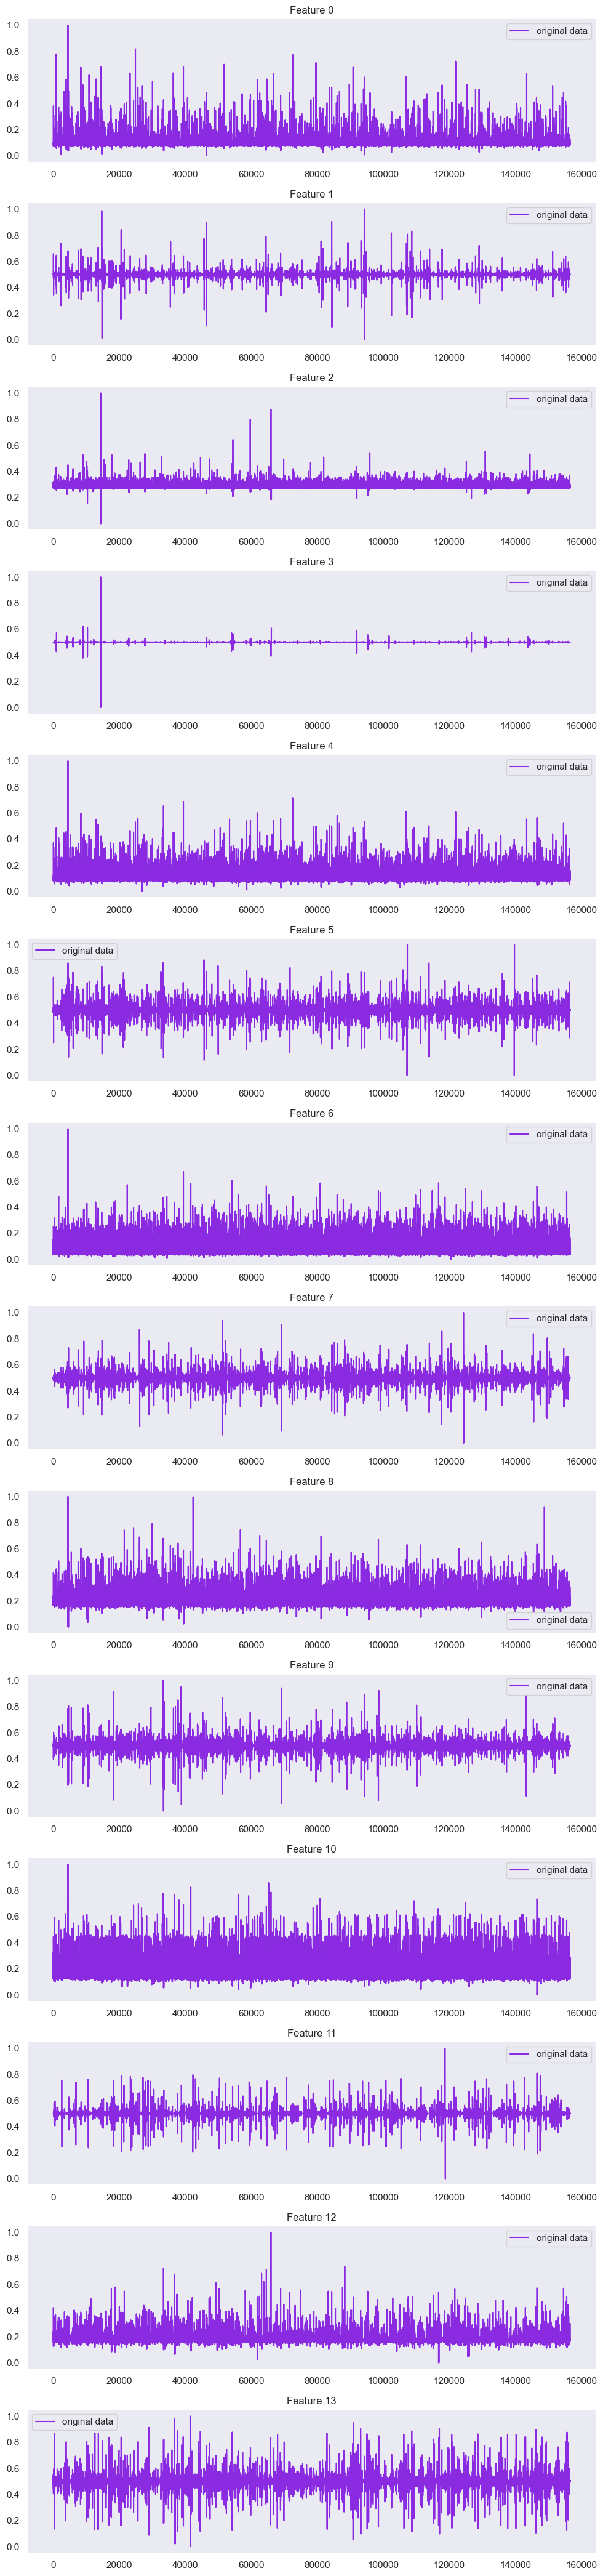

In [59]:
# 1. Извлечь данные из train_loader в виде numpy массива
anom_data = []
for batch in anomaly_loader:
    batch = batch.squeeze(1)  # убираем лишнее измерение
    batch = batch.numpy()  # преобразуем в numpy array
    for seq in batch:
        anom_data.append(seq)
anom_data = np.array(anom_data)

# 2. Перестроить данные в подходящий формат для построения графиков
anom_data = anom_data.reshape(-1, seq_len, n_features)

# 3. Создать подграфики для каждой фичи
fig, axs = plt.subplots(n_features, 1, figsize=(10, n_features * 3))

# 4. Построить график для каждой фичи
for i in range(n_features):
    line, = axs[i].plot(anom_data[:, 0, i], color='blueviolet', label='original data')
    for j in range(1, seq_len):
        axs[i].plot(anom_data[:, j, i], color='blueviolet')
    axs[i].set_title(f'Feature {i}')
    axs[i].legend(handles=[line])  # Добавить легенду

plt.tight_layout()
plt.show()

In [60]:
def predict(model, dataset):
    predictions, losses = [], []
    criterion = nn.MSELoss(reduction='sum').to(args.device)

    with torch.no_grad():
        model = model.eval()
        for seq_true in dataset:
            seq_true = seq_true.to(device=args.device)
            seq_pred = model(seq_true)

            loss = criterion(seq_pred, seq_true)

            predictions.append(seq_pred.cpu().numpy())
            losses.append(loss.item())
    return predictions, losses

d:\anaconda\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


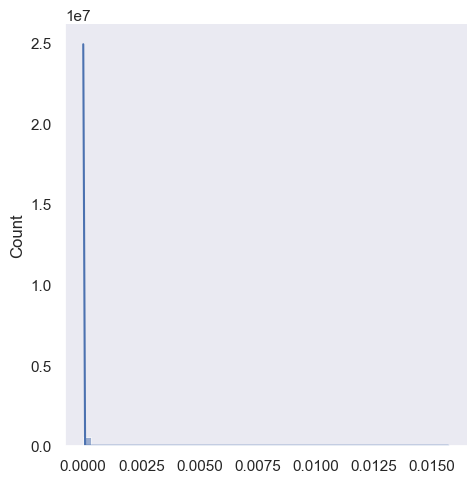

In [61]:
val_pred, val_losses = predict(model,val_loader)
sns.displot(val_losses, bins=50, kde=True);

In [62]:
# train_pred, train_losses = predict(model,train_loader)
# sns.displot(train_losses, bins=50, kde=True);

d:\anaconda\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


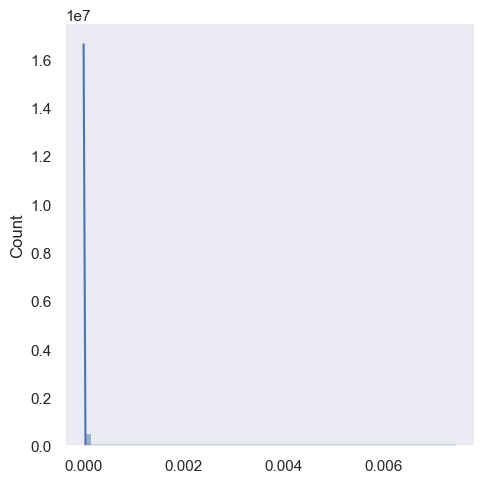

In [63]:
test_pred, test_losses = predict(model,test_loader)
sns.displot(test_losses, bins=50, kde=True);

d:\anaconda\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


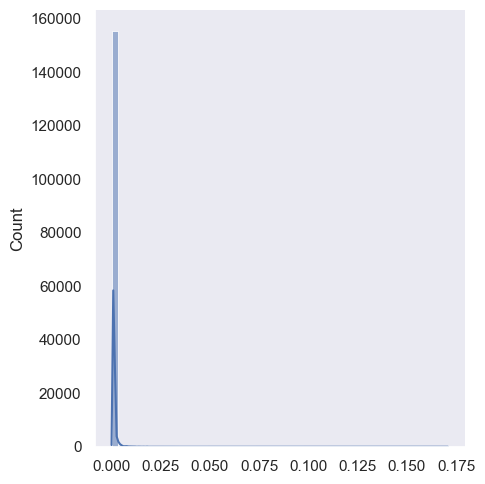

In [64]:
anom_pred, anom_losses = predict(model,anomaly_loader)
sns.displot(anom_losses, bins=50, kde=True);

In [65]:
len(anom_losses)+len(val_losses)

706973

In [66]:
len(val_loader)

550342

In [112]:
Threshold = 0.0001

In [113]:
corect_normal= sum(l<= Threshold for l in val_losses)
print(f'Correct normal predictions: {corect_normal}/{len(val_loader)}')
detected_normal=corect_normal/len(val_loader)
print(f'correct detected normal: {detected_normal}')

corect_test= sum(l<= Threshold for l in test_losses)
print(f'Correct test predictions: {corect_test}/{len(test_loader)}')
detected_test=corect_test/len(test_loader)
print(f'correct detected test: {detected_test}')

corect_anomaly= sum(l> Threshold for l in anom_losses)
print(f'Correct anomaly predictions: {corect_anomaly}/{len(anomaly_loader)}')
detected_anomaly=corect_anomaly/len(anomaly_loader)
print(f'correct detected anomaly: {detected_anomaly}')

Correct normal predictions: 549605/550342
correct detected normal: 0.9986608327185641
Correct test predictions: 549981/550342
correct detected test: 0.9993440442488489
Correct anomaly predictions: 156627/156631
correct detected anomaly: 0.9999744622711979


In [69]:
df['Failure']=0
anom['Failure']=1

In [70]:
th=np.arange( 0.00001,0.005,1e-5)
th.shape

(499,)

In [100]:
corect_normal= sum(l<= th for l in test_losses)
print(f'Correct normal predictions: {corect_normal}/{len(test_loader)}')
detected_normal=corect_normal/len(test_loader)
print(f'correct detected normal: {detected_normal}')
corect_anomaly= sum(l> th for l in anom_losses)
print(f'Correct anomaly predictions: {corect_anomaly}/{len(anomaly_loader)}')
detected_anomaly=corect_anomaly/len(anomaly_loader)
print(f'correct detected anomaly: {detected_anomaly}')

Correct normal predictions: [548481 549161 549445 549609 549716 549794 549860 549907 549945 549981
 550008 550033 550059 550093 550105 550118 550131 550149 550160 550165
 550171 550181 550185 550189 550198 550201 550204 550210 550212 550214
 550219 550223 550225 550228 550231 550233 550236 550238 550240 550240
 550241 550246 550247 550250 550253 550254 550255 550256 550259 550263
 550264 550265 550267 550269 550270 550270 550274 550274 550274 550275
 550275 550276 550276 550276 550277 550279 550279 550280 550281 550281
 550281 550283 550283 550283 550284 550284 550286 550287 550289 550289
 550292 550292 550294 550294 550294 550296 550297 550297 550297 550297
 550297 550298 550299 550299 550300 550300 550300 550300 550300 550301
 550301 550301 550301 550301 550301 550302 550303 550304 550304 550304
 550304 550305 550305 550306 550306 550306 550306 550306 550306 550307
 550307 550307 550307 550307 550307 550307 550307 550308 550308 550308
 550308 550308 550308 550308 550308 550308 550309

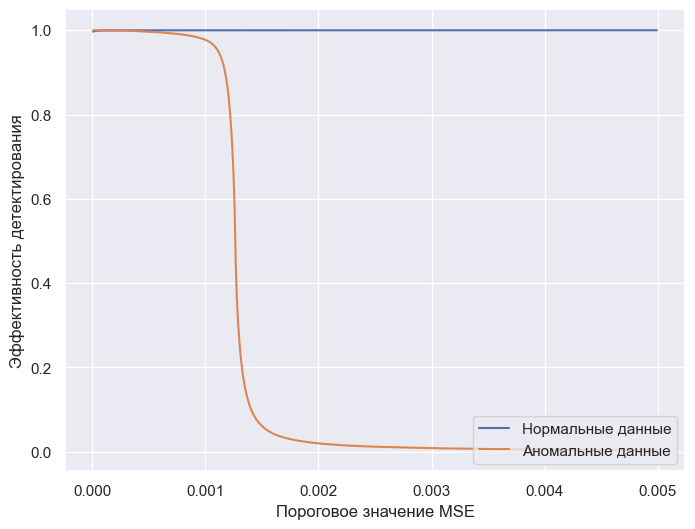

In [101]:
sns.set(style='dark')
plt.figure(figsize=(8,6))
plt.plot(th ,detected_normal)
plt.plot(th ,detected_anomaly)
plt.ylabel('Эффективность детектирования')
plt.xlabel('Пороговое значение MSE')
# plt.ylim(0, 1)
# plt.title('Зависимость эффективности модели от ошибки реконструкции по MSE')
plt.legend(['Нормальные данные','Аномальные данные'], loc='lower right')
plt.grid()
# plt.savefig('pics/threshhold.png', dpi=300)
plt.show();

In [73]:
combined_df = np.concatenate((df[1651026:], anom), axis=0)

In [74]:
combined_df = pd.DataFrame(combined_df, columns=df.columns)

In [75]:
combined_df.shape

(706973, 15)

In [76]:
X=combined_df.drop(['Failure'], axis=1)
y=combined_df['Failure']

In [77]:
combo = Create_dataset(X)
combo_loader=combo.dataset

In [78]:
data_iter = iter(combo_loader)

In [79]:
len(data_iter)

706973

In [80]:
losses=test_losses+anom_losses

In [81]:
Threshold = 0.0001

In [82]:
score = pd.DataFrame(index = X.index)
score['Loss'] = losses
score['Threshold'] = Threshold
score['Anomaly'] = score['Loss'] > score['Threshold']

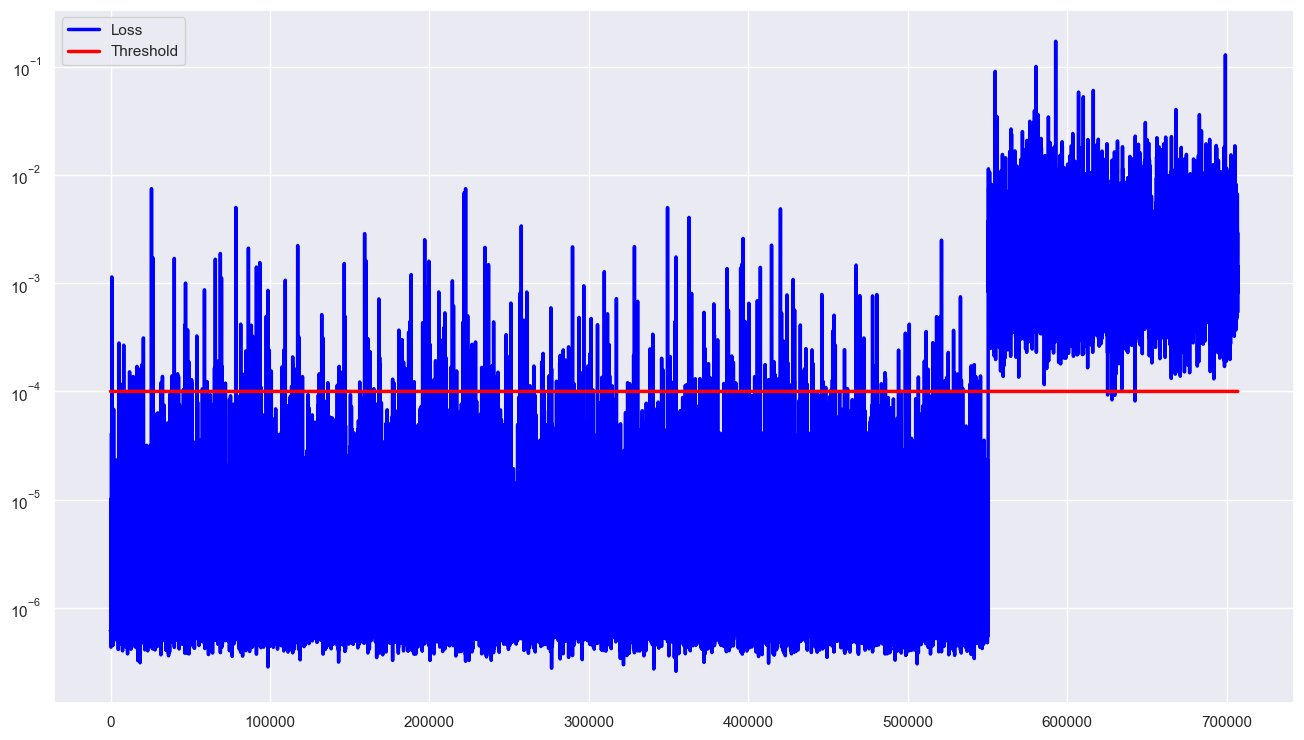

In [83]:
sns.set(style='dark')
score.plot(logy=True, figsize=(16,9), color=['blue','red'],linewidth=2.5)
plt.savefig('score_plot_failure_new.png', dpi=300)
plt.grid()
# Отображение графика
plt.show()

In [114]:
corect_normal= sum(l<= Threshold for l in val_losses)
print(f'Correct normal predictions: {corect_normal}/{len(val_loader)}')
detected_normal=corect_normal/len(val_loader)
print(f'correct detected normal: {detected_normal}')

corect_test= sum(l<= Threshold for l in test_losses)
print(f'Correct test predictions: {corect_test}/{len(test_loader)}')
detected_test=corect_test/len(test_loader)
print(f'correct detected test normal: {detected_test}')

corect_anomaly= sum(l> Threshold for l in anom_losses)
print(f'Correct anomaly predictions: {corect_anomaly}/{len(anomaly_loader)}')
detected_anomaly=corect_anomaly/len(anomaly_loader)
print(f'correct detected anomaly: {detected_anomaly}')

Correct normal predictions: 549605/550342
correct detected normal: 0.9986608327185641
Correct test predictions: 549981/550342
correct detected test normal: 0.9993440442488489
Correct anomaly predictions: 156627/156631
correct detected anomaly: 0.9999744622711979


In [115]:
from sklearn.metrics import  roc_auc_score, classification_report, accuracy_score, f1_score, precision_score, recall_score

In [117]:
def metrics(y_true,y_pred):
    acc=accuracy_score(y_true, y_pred)
    f1=f1_score(y_true, y_pred, average='binary')
    roc_auc=roc_auc_score(y_true, y_pred)
    precision=precision_score(y_true, y_pred)
    recall=recall_score(y_true, y_pred)
    
        # Создание DataFrame
    metrics_df = pd.DataFrame({
        'Метрика': ['Recall', 'Precision', 'F1', 'roc_auc', 'accuracy', 'detected normal', 'detected anomaly'],
        'Значение': [recall, precision, f1, roc_auc, acc, detected_test, detected_anomaly]
    })

    # # Сохранение DataFrame в CSV
    # metrics_df.to_csv('metrics.csv', index=False)
    return metrics_df

In [118]:
score.head()

Loss  Threshold  Anomaly  Anomaly_count  daysToFailure
0  6.208774e-07     0.0001        0              0            234
1  6.163766e-07     0.0001        0              0            233
2  6.193980e-07     0.0001        0              0            232
3  6.246416e-07     0.0001        0              0            231
4  6.207830e-07     0.0001        0              0            230

In [119]:
y.head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Failure, dtype: float64

In [120]:
y.shape

(706973,)

In [121]:
score['Anomaly'].shape

(706973,)

In [122]:
score['Anomaly']=score['Anomaly'].astype(int)

In [123]:
metrics(y, score['Anomaly'])


Метрика  Значение
0            Recall  0.999974
1         Precision  0.997700
2                F1  0.998836
3           roc_auc  0.999659
4          accuracy  0.999484
5   detected normal  0.999344
6  detected anomaly  0.999974

In [93]:
score['Anomaly']

0         0
1         0
2         0
3         0
4         0
         ..
706968    1
706969    1
706970    1
706971    1
706972    1
Name: Anomaly, Length: 706973, dtype: int32

In [94]:
# Добавление колонки Anomaly_count
def count_consecutive_anomalies(anomalies):
    count = 0
    counts = []
    for anomaly in anomalies:
        if anomaly == 1:
            count += 1
        else:
            count = 0
        counts.append(count)
    return counts

score['Anomaly_count'] = count_consecutive_anomalies(score['Anomaly'].values)

score[2000000:]

Empty DataFrame
Columns: [Loss, Threshold, Anomaly, Anomaly_count]
Index: []

In [95]:
score['daysToFailure'] = pd.concat([time_df, time_anom], ignore_index=True)

In [96]:
test_df=pd.read_csv('0a2dbfa5.csv')
test_df.head()

SK_Well Failure1_CulpritCause     Failure2_CulpritCause  \
0  0a2dbfa5            Неизвестно  Старение изоляции кабеля   
1  0a2dbfa5            Неизвестно  Старение изоляции кабеля   
2  0a2dbfa5            Неизвестно  Старение изоляции кабеля   
3  0a2dbfa5            Неизвестно  Старение изоляции кабеля   
4  0a2dbfa5            Неизвестно  Старение изоляции кабеля   

  Failure3_CulpritCause Failure4_CulpritCause Failure5_CulpritCause  \
0            Неизвестно            Неизвестно            Неизвестно   
1            Неизвестно            Неизвестно            Неизвестно   
2            Неизвестно            Неизвестно            Неизвестно   
3            Неизвестно            Неизвестно            Неизвестно   
4            Неизвестно            Неизвестно            Неизвестно   

  Failure6_CulpritCause Failure7_CulpritCause  MeasureMRM12  MeasureMRM142  \
0            Неизвестно            Неизвестно          16.0            8.0   
1            Неизвестно            Неизвестно          16.0            8.0   
2            Неизвестно            Неизвестно          16.0            8.0   
3            Неизвестно            Неизвестно          16.0            8.0   
4            Неизвестно            Неизвестно          15.0            7.8   

   MeasureMRM143  MeasureMRM187  MeasureMRM188  MeasureMRM219  daysToFailure  \
0           21.4           62.1           36.0         9999.0            878   
1           21.4           61.8           36.0         9999.0            877   
2           21.3           62.1           36.0         9999.0            876   
3           21.5           61.8           36.0         9999.0            875   
4           21.6           62.0           36.0         9999.0            874   

   MeasureMRM204  
0            0.3  
1            0.0  
2            0.2  
3            0.0  
4            0.0

In [73]:
from scipy.fft import fft, ifft

In [74]:
def apply_fft(data, columns):
    # Применяем FFT только к указанным столбцам
    fft_features = {}
    for column in columns:
        if column in data.columns:
            # Преобразуем данные в числовой тип, игнорируя ошибки
            numeric_data = pd.to_numeric(data[column], errors='coerce').fillna(0).to_numpy()
            if numeric_data.ndim == 1:  # Проверяем, что это одномерный массив
                fft_result = fft(numeric_data)
                # Извлекаем реальные и мнимые части
                fft_real = np.real(fft_result)
                fft_imag = np.imag(fft_result)
                # Добавляем результаты FFT в словарь
                fft_features[f'{column}_fft_real'] = fft_real
                fft_features[f'{column}_fft_imag'] = fft_imag
    return pd.DataFrame(fft_features)

In [90]:
fft_test=apply_fft(test_df, test_df[['MeasureMRM12', 'MeasureMRM142', 'MeasureMRM143', 'MeasureMRM187', 
               'MeasureMRM188', 'MeasureMRM219', 'MeasureMRM204']] )

In [91]:
fft_test=fft_test[['MeasureMRM12_fft_real',
       'MeasureMRM12_fft_imag', 'MeasureMRM142_fft_real',
       'MeasureMRM142_fft_imag', 'MeasureMRM143_fft_real',
       'MeasureMRM143_fft_imag', 'MeasureMRM187_fft_real',
       'MeasureMRM187_fft_imag', 'MeasureMRM188_fft_real',
       'MeasureMRM188_fft_imag', 'MeasureMRM219_fft_real',
       'MeasureMRM219_fft_imag', 'MeasureMRM204_fft_real',
       'MeasureMRM204_fft_imag']]

In [92]:
fft_test= pd.DataFrame(scaler.fit_transform(fft_test), columns=columns)

In [93]:
test = Create_dataset(fft_test)
test_loader=test.dataset

In [94]:
# # 1. Извлечь данные из train_loader в виде numpy массива
# test_data = []
# for batch in test_loader:
#     batch = batch.squeeze(1)  # убираем лишнее измерение
#     batch = batch.numpy()  # преобразуем в numpy array
#     for seq in batch:
#         test_data.append(seq)
# test_data = np.array(test_data)

# # 2. Перестроить данные в подходящий формат для построения графиков
# test_data = test_data.reshape(-1, seq_len, n_features)

# # 3. Создать подграфики для каждой фичи
# fig, axs = plt.subplots(n_features, 1, figsize=(10, n_features * 3))

# # 4. Построить график для каждой фичи
# for i in range(n_features):
#     line, = axs[i].plot(test_data[:, 0, i], color='blueviolet', label='original data')
#     for j in range(1, seq_len):
#         axs[i].plot(test_data[:, j, i], color='blueviolet')
#     axs[i].set_title(f'Feature {i}')
#     axs[i].legend(handles=[line])  # Добавить легенду

# plt.tight_layout()
# plt.show()

In [95]:
test_pred, test_losses = predict(model,test_loader)

In [104]:
Threshold=0.03

In [105]:
score_test = pd.DataFrame(index = test_df.index)
score_test['Loss'] = test_losses
score_test['Threshold'] = Threshold
score_test['Anomaly'] = score_test['Loss'] > score_test['Threshold']

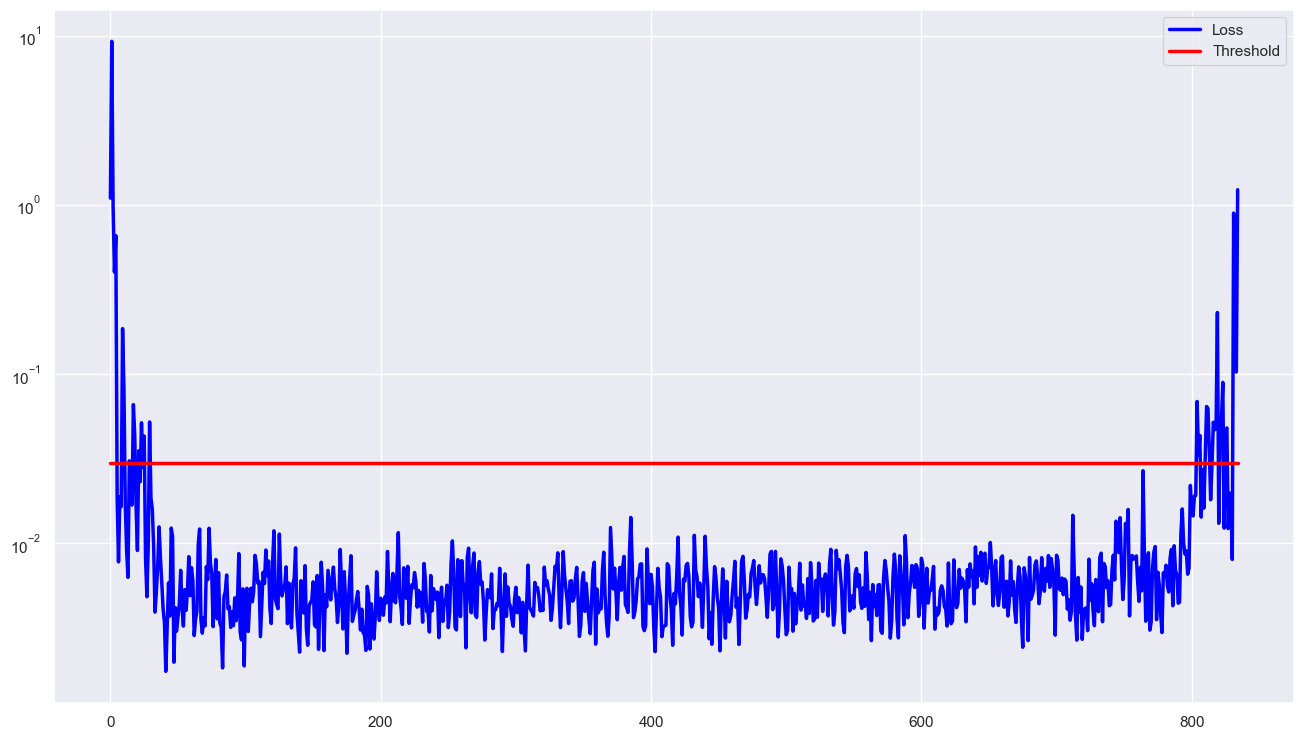

In [106]:
sns.set(style='dark')
score_test.plot(logy=True, figsize=(16,9), color=['blue','red'],linewidth=2.5)
plt.savefig('score_plot_test_all.png', dpi=300)
plt.grid()
# Отображение графика
plt.show()

In [ ]:
score_test.head()

Loss  Threshold  Anomaly
0  0.210630       0.04     True
1  1.241671       0.04     True
2  0.064254       0.04     True
3  0.429794       0.04     True
4  0.332998       0.04     True

In [ ]:
test_pred

[array([[[0.7466179 , 0.5370014 , 0.7718675 , 0.5710201 , 0.82243985,
          0.5083873 , 0.85545474, 0.52480924, 0.9220641 , 0.4649948 ,
          0.8908392 , 0.5395917 , 0.922294  , 0.5896807 ]]], dtype=float32),
 array([[[ 0.04573432,  0.6912813 ,  0.01483966,  0.9980248 ,
           0.10726873,  1.1891254 ,  0.18026376,  1.2376612 ,
           0.37589556,  0.6451477 ,  0.23371312, -0.5805526 ,
          -0.03036474,  0.9642813 ]]], dtype=float32),
 array([[[-0.0022724 ,  0.24434045,  0.07157364,  0.9307628 ,
          -0.04520517,  0.4318267 ,  0.00272322,  0.19746044,
           0.22791225,  0.32584286,  0.0167546 ,  0.2436294 ,
           0.3931905 ,  0.5272474 ]]], dtype=float32),
 array([[[-0.0639682 ,  0.08895028,  0.12175287,  0.8387627 ,
           0.19231546,  0.66787016, -0.3124107 ,  0.048354  ,
           0.26611722,  1.1802844 ,  0.25722843,  0.36713198,
           0.5402955 ,  0.094419  ]]], dtype=float32),
 array([[[ 0.06681877,  1.4042056 ,  0.11329817,  0.6163742 

In [ ]:
# Функция для восстановления временных рядов
def restore_time_series(predictions, columns):
    restored_columns = {}
    for column in columns:
        real_col = f'{column}_fft_real'
        imag_col = f'{column}_fft_imag'
        
        if real_col in predictions and imag_col in predictions:
            fft_real = predictions[real_col].to_numpy()
            fft_imag = predictions[imag_col].to_numpy()
            restored_columns[column] = apply_ifft(fft_real, fft_imag)
    return pd.DataFrame(restored_columns)

In [ ]:
# Преобразование предсказаний в массив NumPy
predictions_np = np.array(test_pred).reshape(-1, len(fft_test.columns))

# Восстановление временных рядов
restored_df = restore_time_series(predictions_np, columns)

C:\Users\пользователь\AppData\Local\Temp\ipykernel_12568\208223594.py:8: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if real_col in predictions and imag_col in predictions:


In [ ]:
predictions_np.shape

(600, 14)

In [ ]:
predictions_df

MeasureMRM12_fft_real  MeasureMRM12_fft_imag  MeasureMRM142_fft_real  \
0                 0.746618               0.537001                0.771868   
1                 0.045734               0.691281                0.014840   
2                -0.002272               0.244340                0.071574   
3                -0.063968               0.088950                0.121753   
4                 0.066819               1.404206                0.113298   
..                     ...                    ...                     ...   
595               0.055703               0.492270                0.023902   
596               0.059959               0.508506                0.037441   
597               0.064325               0.494095                0.037022   
598               0.070587               0.488660                0.021764   
599               0.062231               0.471693                0.019467   

     MeasureMRM142_fft_imag  MeasureMRM143_fft_real  MeasureMRM143_fft_imag  \
0                  0.571020                0.822440                0.508387   
1                  0.998025                0.107269                1.189125   
2                  0.930763               -0.045205                0.431827   
3                  0.838763                0.192315                0.667870   
4                  0.616374                0.109409                0.103780   
..                      ...                     ...                     ...   
595                0.450032                0.056408                0.483926   
596                0.509999                0.054663                0.449841   
597                0.495199                0.052660                0.441483   
598                0.479136                0.058850                0.428362   
599                0.437149                0.061811                0.478957   

     MeasureMRM187_fft_real  MeasureMRM187_fft_imag  MeasureMRM188_fft_real  \
0                  0.855455                0.524809                0.922064   
1                  0.180264                1.237661                0.375896   
2                  0.002723                0.197460                0.227912   
3                 -0.312411                0.048354                0.266117   
4                  0.147009               -0.059794                0.188630   
..                      ...                     ...                     ...   
595                0.088204                0.552719                0.063289   
596                0.090378                0.508835                0.064828   
597                0.092842                0.523040                0.058896   
598                0.094883                0.519644                0.066926   
599                0.088866                0.562171                0.061594   

     MeasureMRM188_fft_imag  MeasureMRM219_fft_real  MeasureMRM219_fft_imag  \
0                  0.464995                0.890839                0.539592   
1                  0.645148                0.233713               -0.580553   
2                  0.325843                0.016755                0.243629   
3                  1.180284                0.257228                0.367132   
4                  0.593071                0.058070                0.516466   
..                      ...                     ...                     ...   
595                0.529545                0.113843                0.506250   
596                0.536396                0.128226                0.585660   
597                0.539929                0.119090                0.561181   
598                0.498630                0.098945                0.493826   
599                0.542646                0.104519                0.476417   

     MeasureMRM204_fft_real  MeasureMRM204_fft_imag  
0                  0.922294                0.589681  
1                 -0.030365                0.964281  
2                  0.393191                0.527247  
3                

In [ ]:
restored_df.shape

(0, 0)

In [ ]:
# combo_data_np = torch.cat([batch for batch in combo_loader], dim=0).detach().cpu().numpy()

# # 2. Перестроить данные в подходящий формат для построения графиков
# combo_data_np = combo_data_np.reshape(-1, seq_len, n_features)

# # 3. Получить предсказания модели
# preds = []
# with torch.no_grad():
#     model = model.eval()
#     for seq_true in combo_loader:
#         seq_true = seq_true.to(args.device)
#         seq_true = seq_true.reshape((-1, seq_len, n_features))

#         seq_pred = model(seq_true)
#         preds.append(seq_pred.cpu().numpy())
# preds = np.concatenate(preds, axis=0)

# # 4. Создать подграфики для каждой фичи
# fig, axs = plt.subplots(n_features, 1, figsize=(10, n_features * 3))

# # 5. Построить график для каждой фичи
# for i in range(n_features):
    

#     line2, = axs[i].plot(preds[:, 0, i], color='orange', label='predictions')
#     line1, = axs[i].plot(combo_data_np[:, 0, i], color='blueviolet', label='original data')
#     for j in range(1, seq_len):
#         axs[i].plot(combo_data_np[:, j, i], color='blueviolet')
#         axs[i].plot(preds[:, j, i], color='orange')
#     axs[i].set_title(f'Feature {i}')
#     axs[i].legend(handles=[line1, line2])
# # plt.savefig('preds/original 3d.png', dpi=300)
# plt.tight_layout()

# plt.show()
